In [2]:
# Imports
import os
from __future__ import print_function
import time
import warnings
warnings.filterwarnings('ignore')
os.environ['KERAS_BACKEND']='tensorflow'

# UTILS
from HANutils import resfromdict, normPSSM, getconsensus, Kldivergence, get_activations,draw_logo, HSW
import _pickle as cPickle
import pandas as pd

#Data
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC, generic_protein
import os, operator
import numpy, math, random
import warnings

import pandas as pd
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import normalize

# Graphics
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import seaborn 

# Seed for reproducibility
numpy.random.seed(8)

In [3]:
# Open saved values from HAN_get_PSSM
SEQ, consensus = cPickle.load(open("SEQ3_PF00028.pkl","rb"))
# Distance info
print("[!] Data sucessfully loaded")
print("SEQ shape: " , len(SEQ),len(SEQ[1]))
print("Consensus", consensus)

# Data format for keras: (number_of_sequences,lenght_of_sequences,number_of_features)
# Manual Tokenizer
CHARS = list(['-','L','V','I','M','C','A','G','S','T','P','F','Y','W','E','D','N','Q','K','R','H'])
DCHARS = {'-':0,'L':1,'V':2,'I':3,'M':4,'C':5,'A':6,'G':7,'S':8,'T':9,'P':10,'F':11,'Y':12,'W':13,'E':14,'D':15,'N':16,'Q':17,'K':18,'R':19,'H':20}
VOCAB_SIZE = len(DCHARS)
SEQ_LENGTH=len(SEQ[1])

START=19

[!] Data sucessfully loaded
SEQ shape:  6210 93
Consensus VEVHIPENAPVGTSVIQLHATDADIGSNAEIRYIFGQVAPKRLFALNNTTGLITVQRSLDREETAIHKVTVLASDG-SSTP--ARATVTINVT


In [4]:
#=================================================#
#   VISUALIZE ACTIVATIONS                         #
#   TRANSFER TO UTILS                             #
#=================================================#
%matplotlib inline
plt.style.use('seaborn-ticks')
# seaborn.set_palette("husl")

#=================================================#
#   ACTIVATION FROM LAYERS                        #
#=================================================#
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

#=================================================#
#   CONSENSUS PLOTTING                            #
#=================================================#
from matplotlib import transforms
import matplotlib.patheffects
from matplotlib.font_manager import FontProperties
import matplotlib as mpl



class Scale(matplotlib.patheffects.RendererBase):
    def __init__(self, sx, sy=None):
        self._sx = sx
        self._sy = sy

    def draw_path(self, renderer, gc, tpath, affine, rgbFace):
        affine = affine.identity().scale(self._sx, self._sy)+affine
        renderer.draw_path(gc, tpath, affine, rgbFace)

def draw_logo(L, SEQUENCE, ACT, fontfamily='Arial', size=90):
    all_scores = dict(zip(list(numpy.arange(L)), ACT))
 
    if fontfamily == 'xkcd':
        plt.xkcd()
    else:
        mpl.rcParams['font.family'] = fontfamily

    fig, ax = plt.subplots(figsize=(60,20),dpi=300)

    font = FontProperties()
    font.set_size(size)
#     font.set_weight('bold')
    
    #font.set_family(fontfamily)

    ax.set_xticks(range(1,L+1))    
    ax.set_yticks(range(0,1))
    ax.set_xticklabels(range(START,L+START), rotation=90, fontsize=12) 
    ax.set_yticklabels(numpy.arange(0,max(ACT),1), fontsize=12) 
    ax.set_xticklabels(xticks, rotation=90, fontsize=40);
    seaborn.despine(ax=ax, trim=True)
    
    trans_offset = transforms.offset_copy(ax.transData, 
                                          fig=fig, 
                                          x=1, 
                                          y=0, 
                                          units='dots')
   
    for index, scores in enumerate(all_scores):
        yshift = 0
        txt = ax.text(index+1, 
                      0, 
                      str(SEQUENCE[index]), 
#                       transform=trans_offset,
                      fontsize=80,# color=COLOR_SCHEME[base],
                      ha='center',
                      fontproperties=font
                     )
        
        txt.set_path_effects([Scale(.8, dictionary[scores]*10)])
        fig.canvas.draw()
        window_ext = txt.get_window_extent(txt._renderer)
        yshift = window_ext.height*dictionary[scores]
        trans_offset = transforms.offset_copy(txt._transform, 
                                              fig=fig,
                                              y=yshift,
                                              units='points')
    trans_offset = transforms.offset_copy(ax.transData, 
                                          fig=fig, 
                                          x=1, 
                                          y=0, 
                                          units='points')    
    plt.show()
    

In [5]:
## Files to load
# res_attn  residue attention
# res_model output res model (pre traiing)
# seq_output output of the dense 1
# resi window residue array
attn1 = numpy.loadtxt("act.csv",  delimiter=",")
attn1 = attn1.reshape((attn1.shape[0],1))
attn1 = normalize(attn1,norm='max',axis=0).ravel()
dist1 = numpy.loadtxt("distance.csv",  delimiter=",")
resi1 = numpy.loadtxt("resi.csv", delimiter=",")

(0, 1)

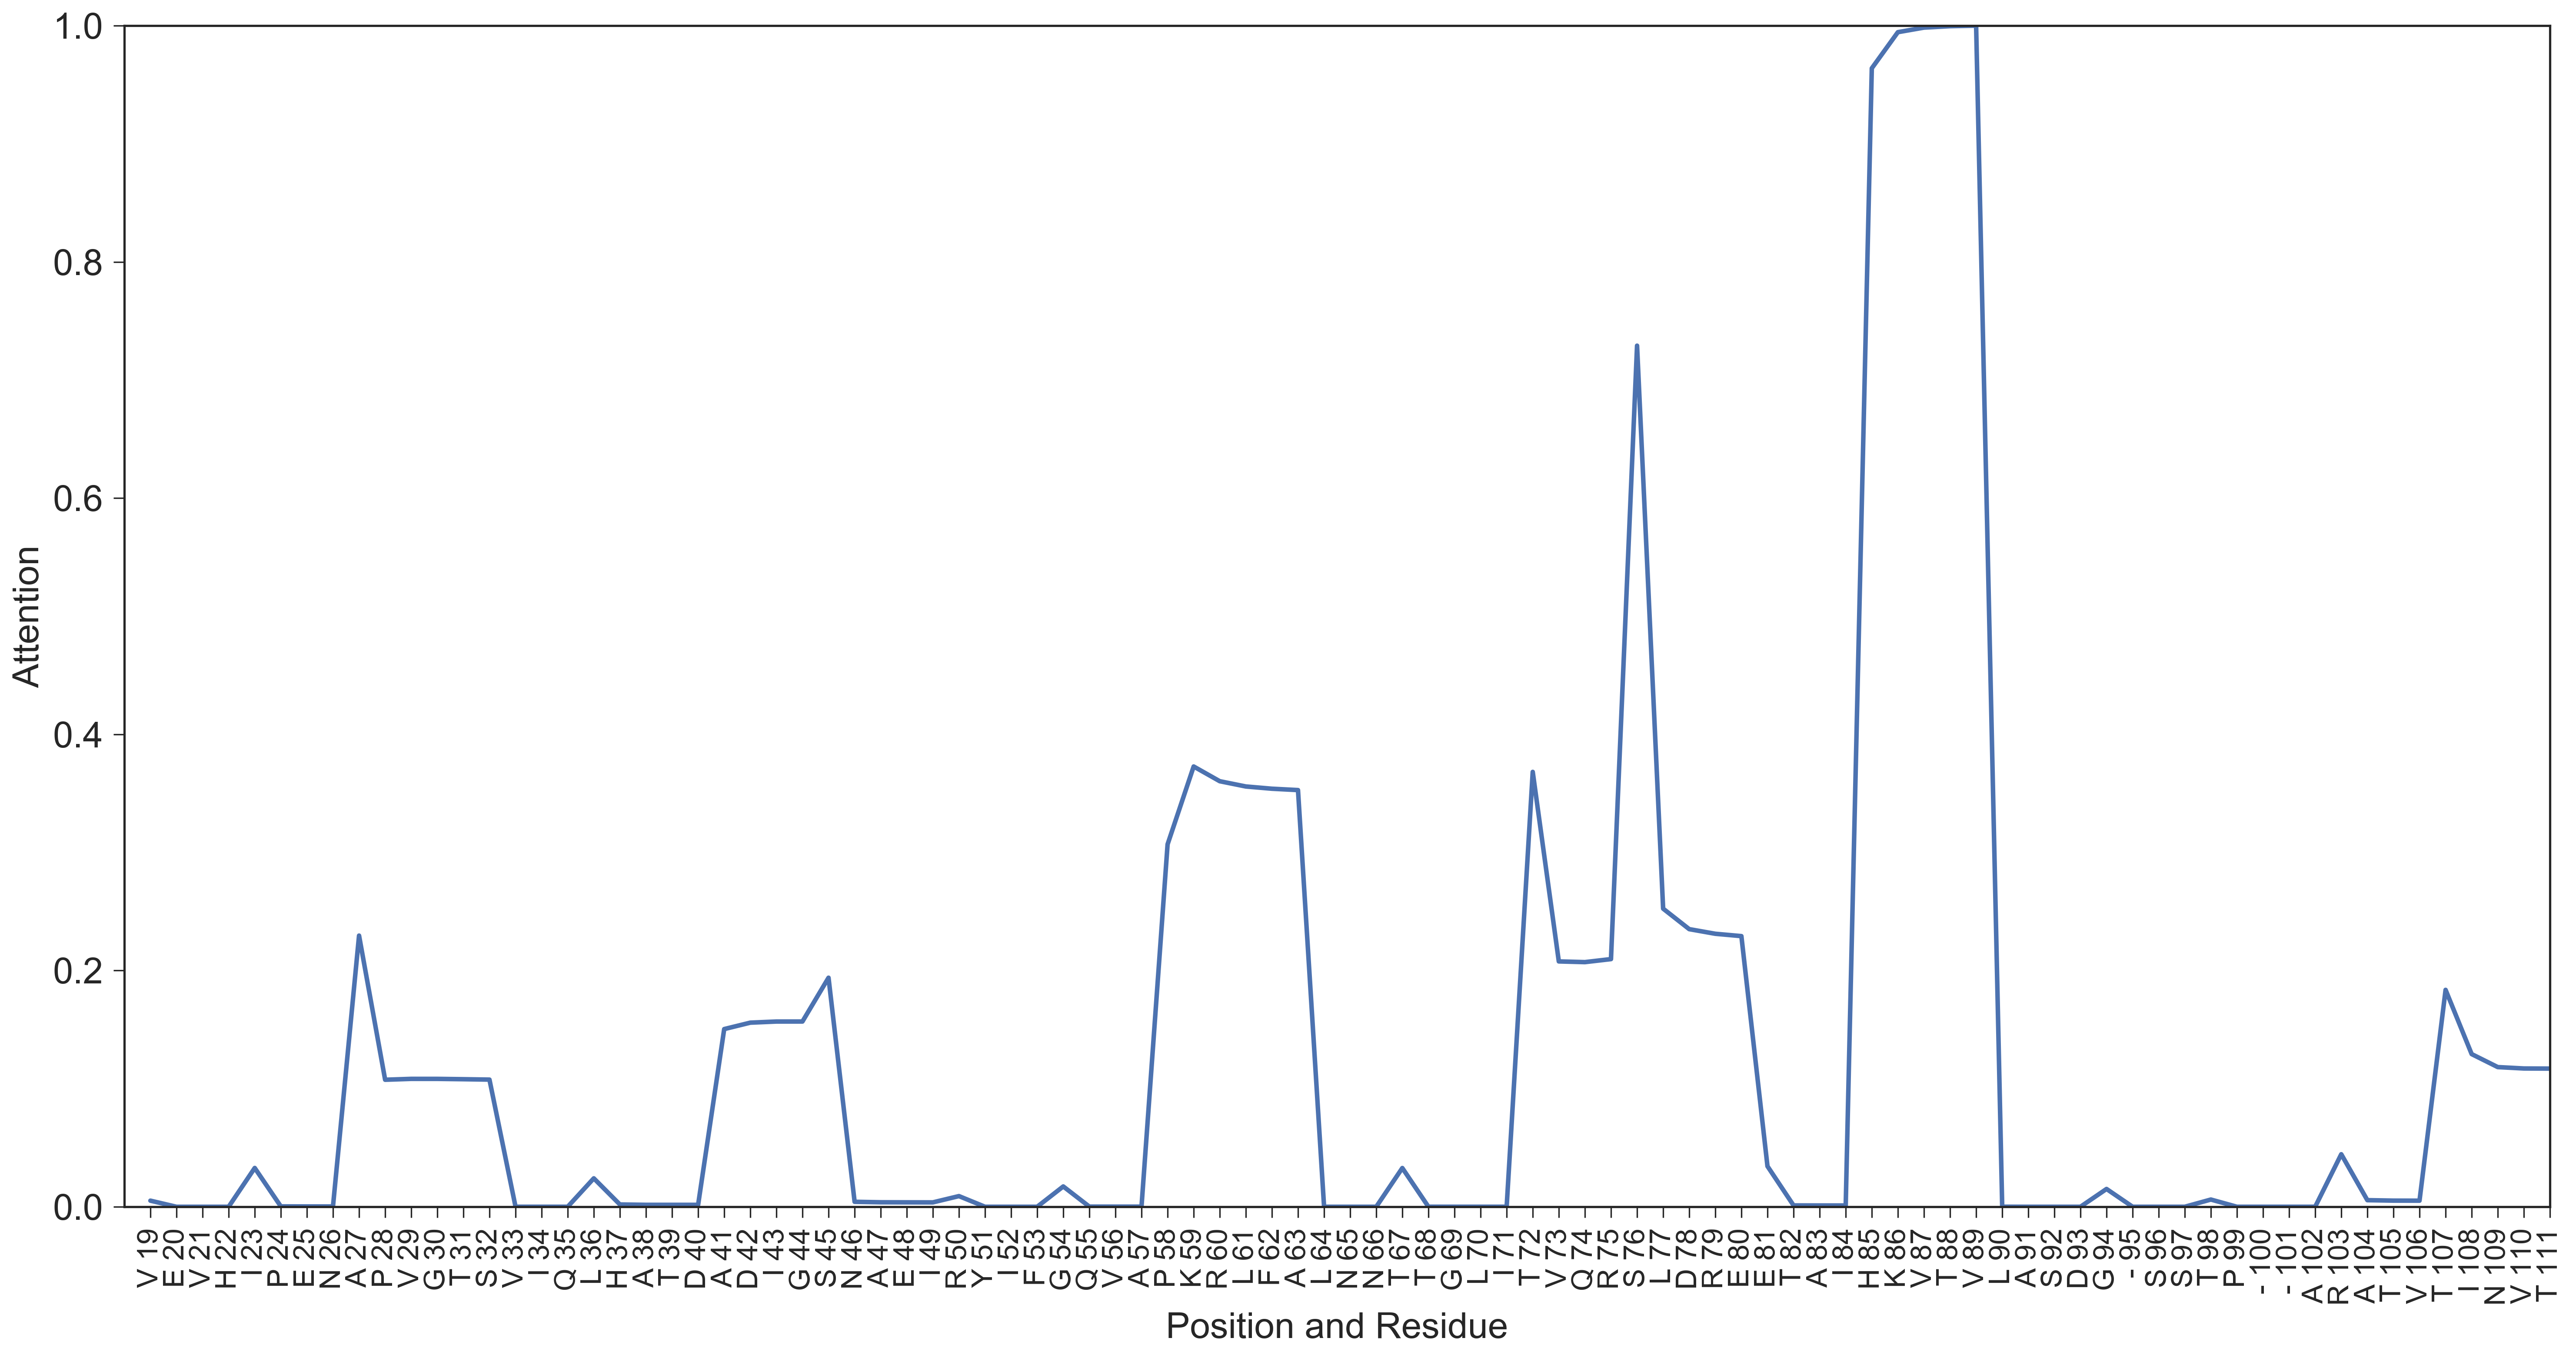

In [6]:
# Activation Plot
SEQ_LENGTH=attn1.shape[0]
RES=[consensus]
nums = numpy.arange(0,SEQ_LENGTH,1);
xticks = [(RES[0][i-START]+' '+str(int(i))) for i in range(START,SEQ_LENGTH+START)]
seaborn.set_style("white")
seaborn.set_style("ticks")
seaborn.set_context("paper",rc={"lines.linewidth": 2.5})

f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax = seaborn.tsplot(data=[attn1]);
ax.set_ylabel("Attention", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

(0, 1)

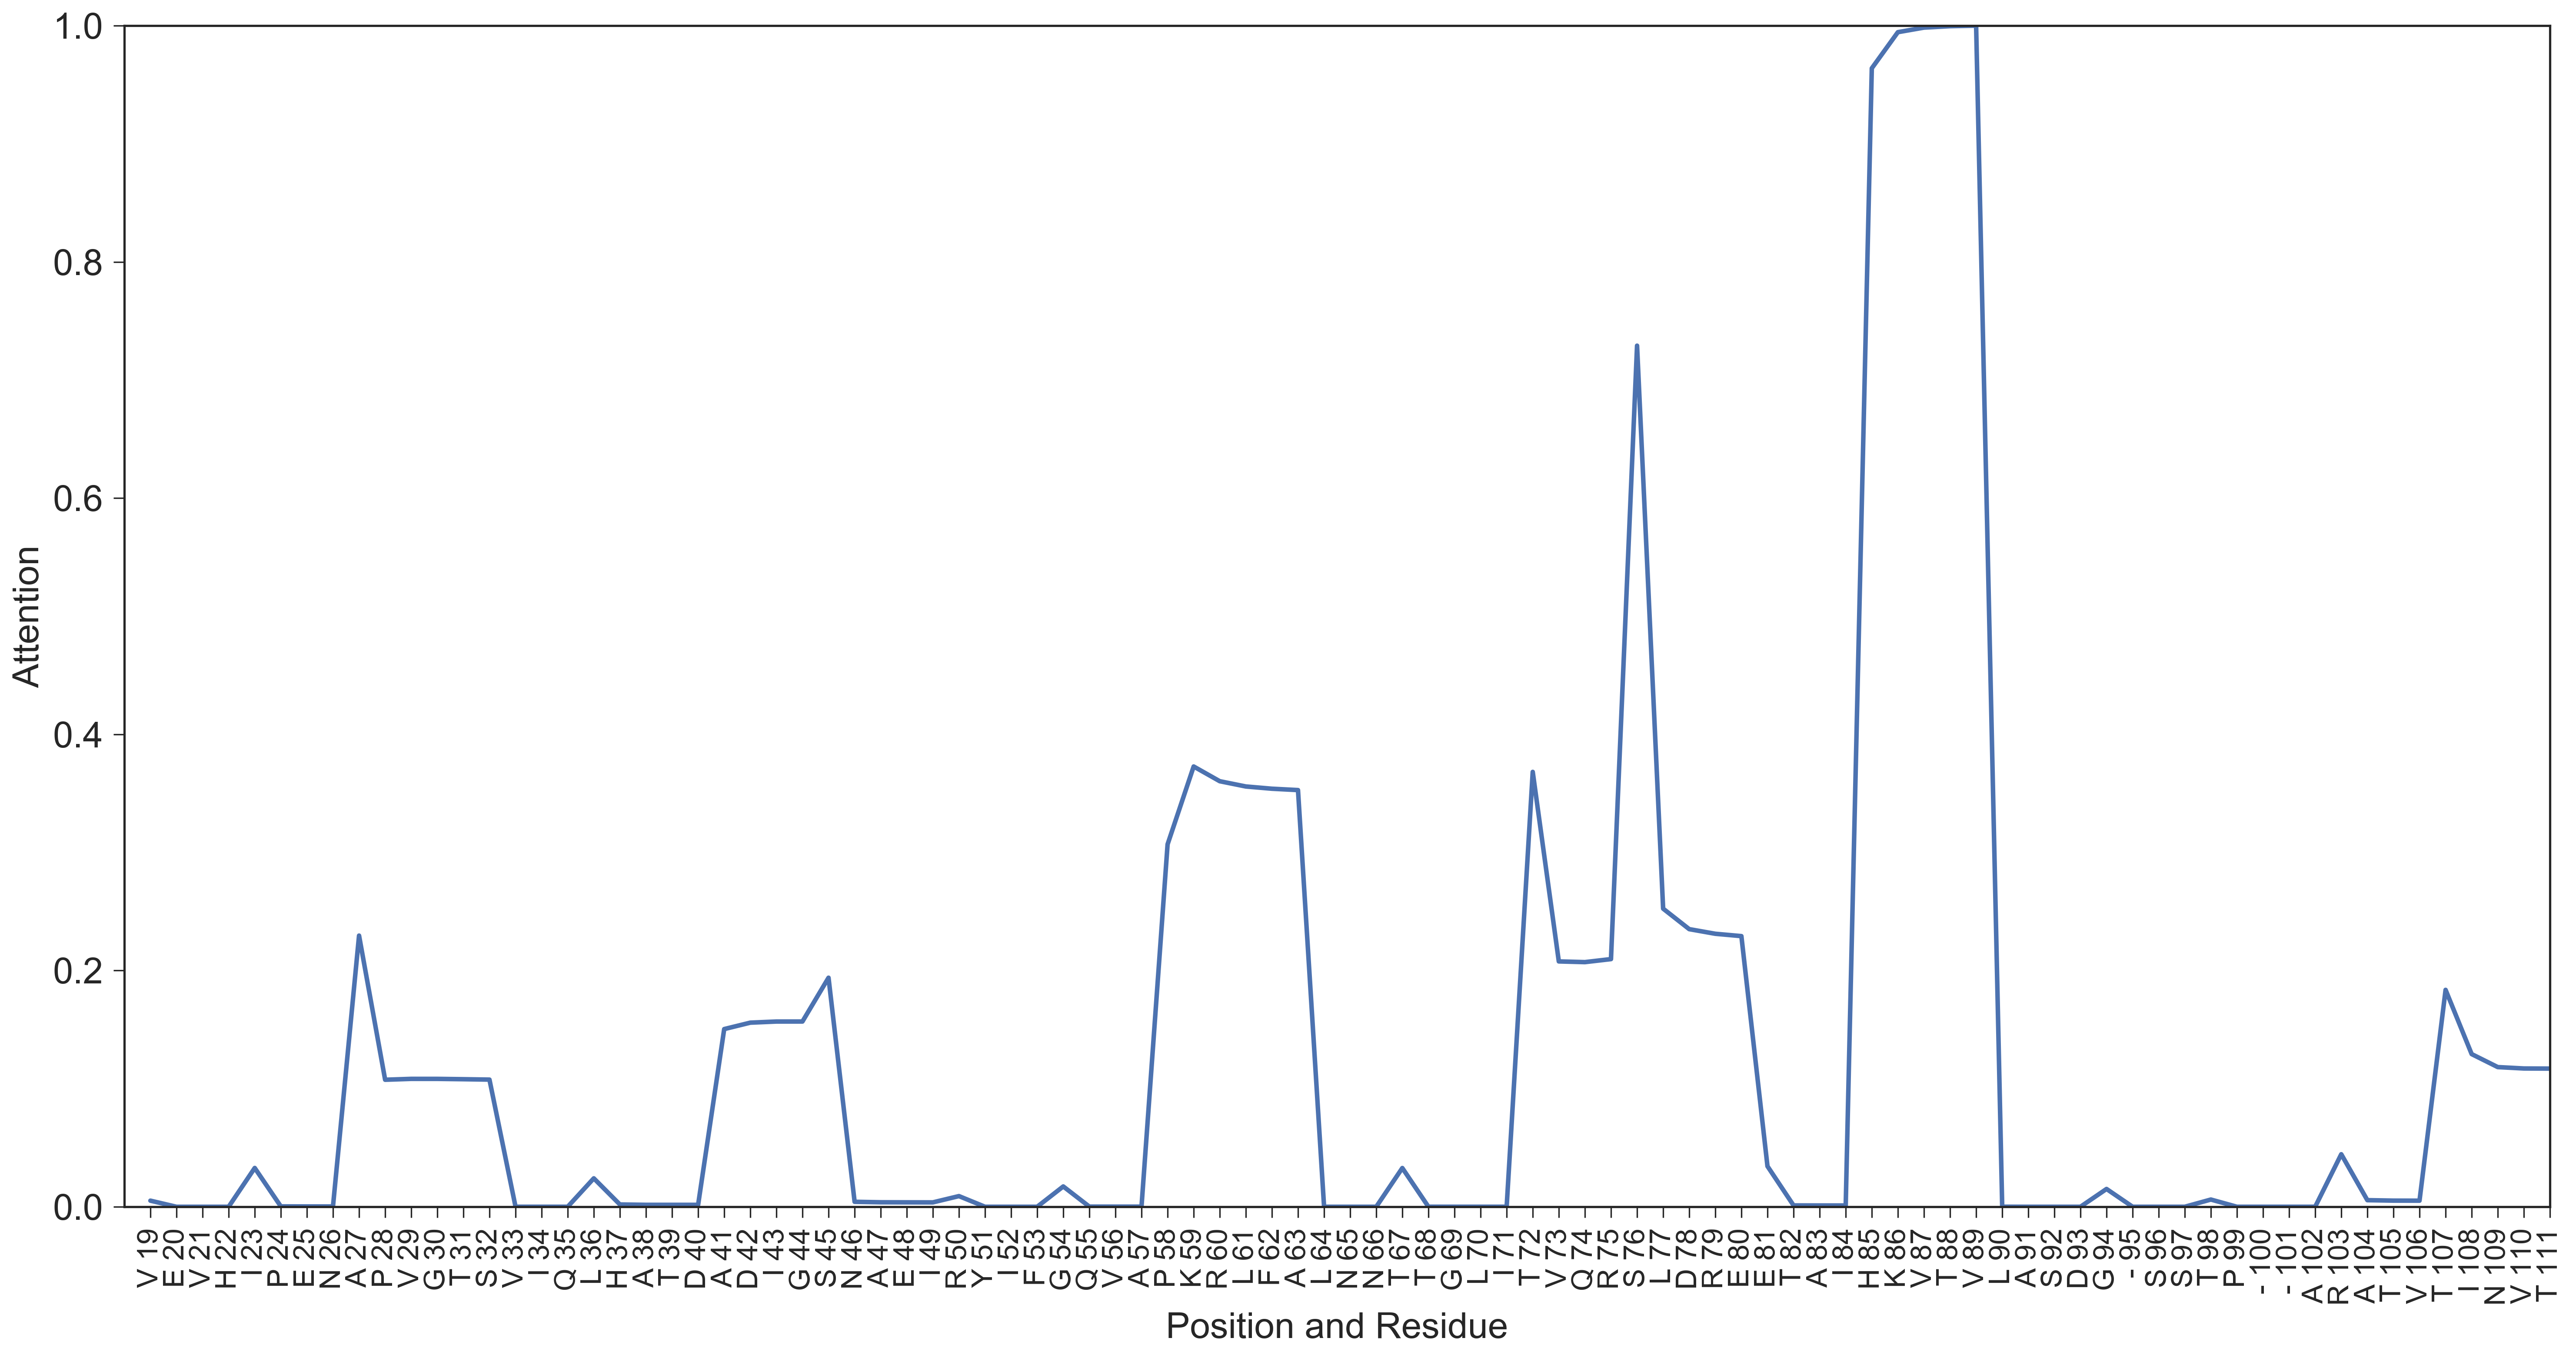

In [7]:
# Sequence Logo
data=normalize(attn1.reshape((1,attn1.shape[0])),norm='max')#,

# data=numpy.mean(data,axis=0)
data_= attn1
data2 = numpy.tril(data_)

# seq_dict = numpy.arange(SEQ_LENGTH)
# dictionary = dict(zip(list(seq_dict), data))    
# draw_logo(SEQ_LENGTH,RES[0],data, 'Arial')

# Normalize Attn array
f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax = seaborn.tsplot(data=data);
ax.set_ylabel("Attention", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

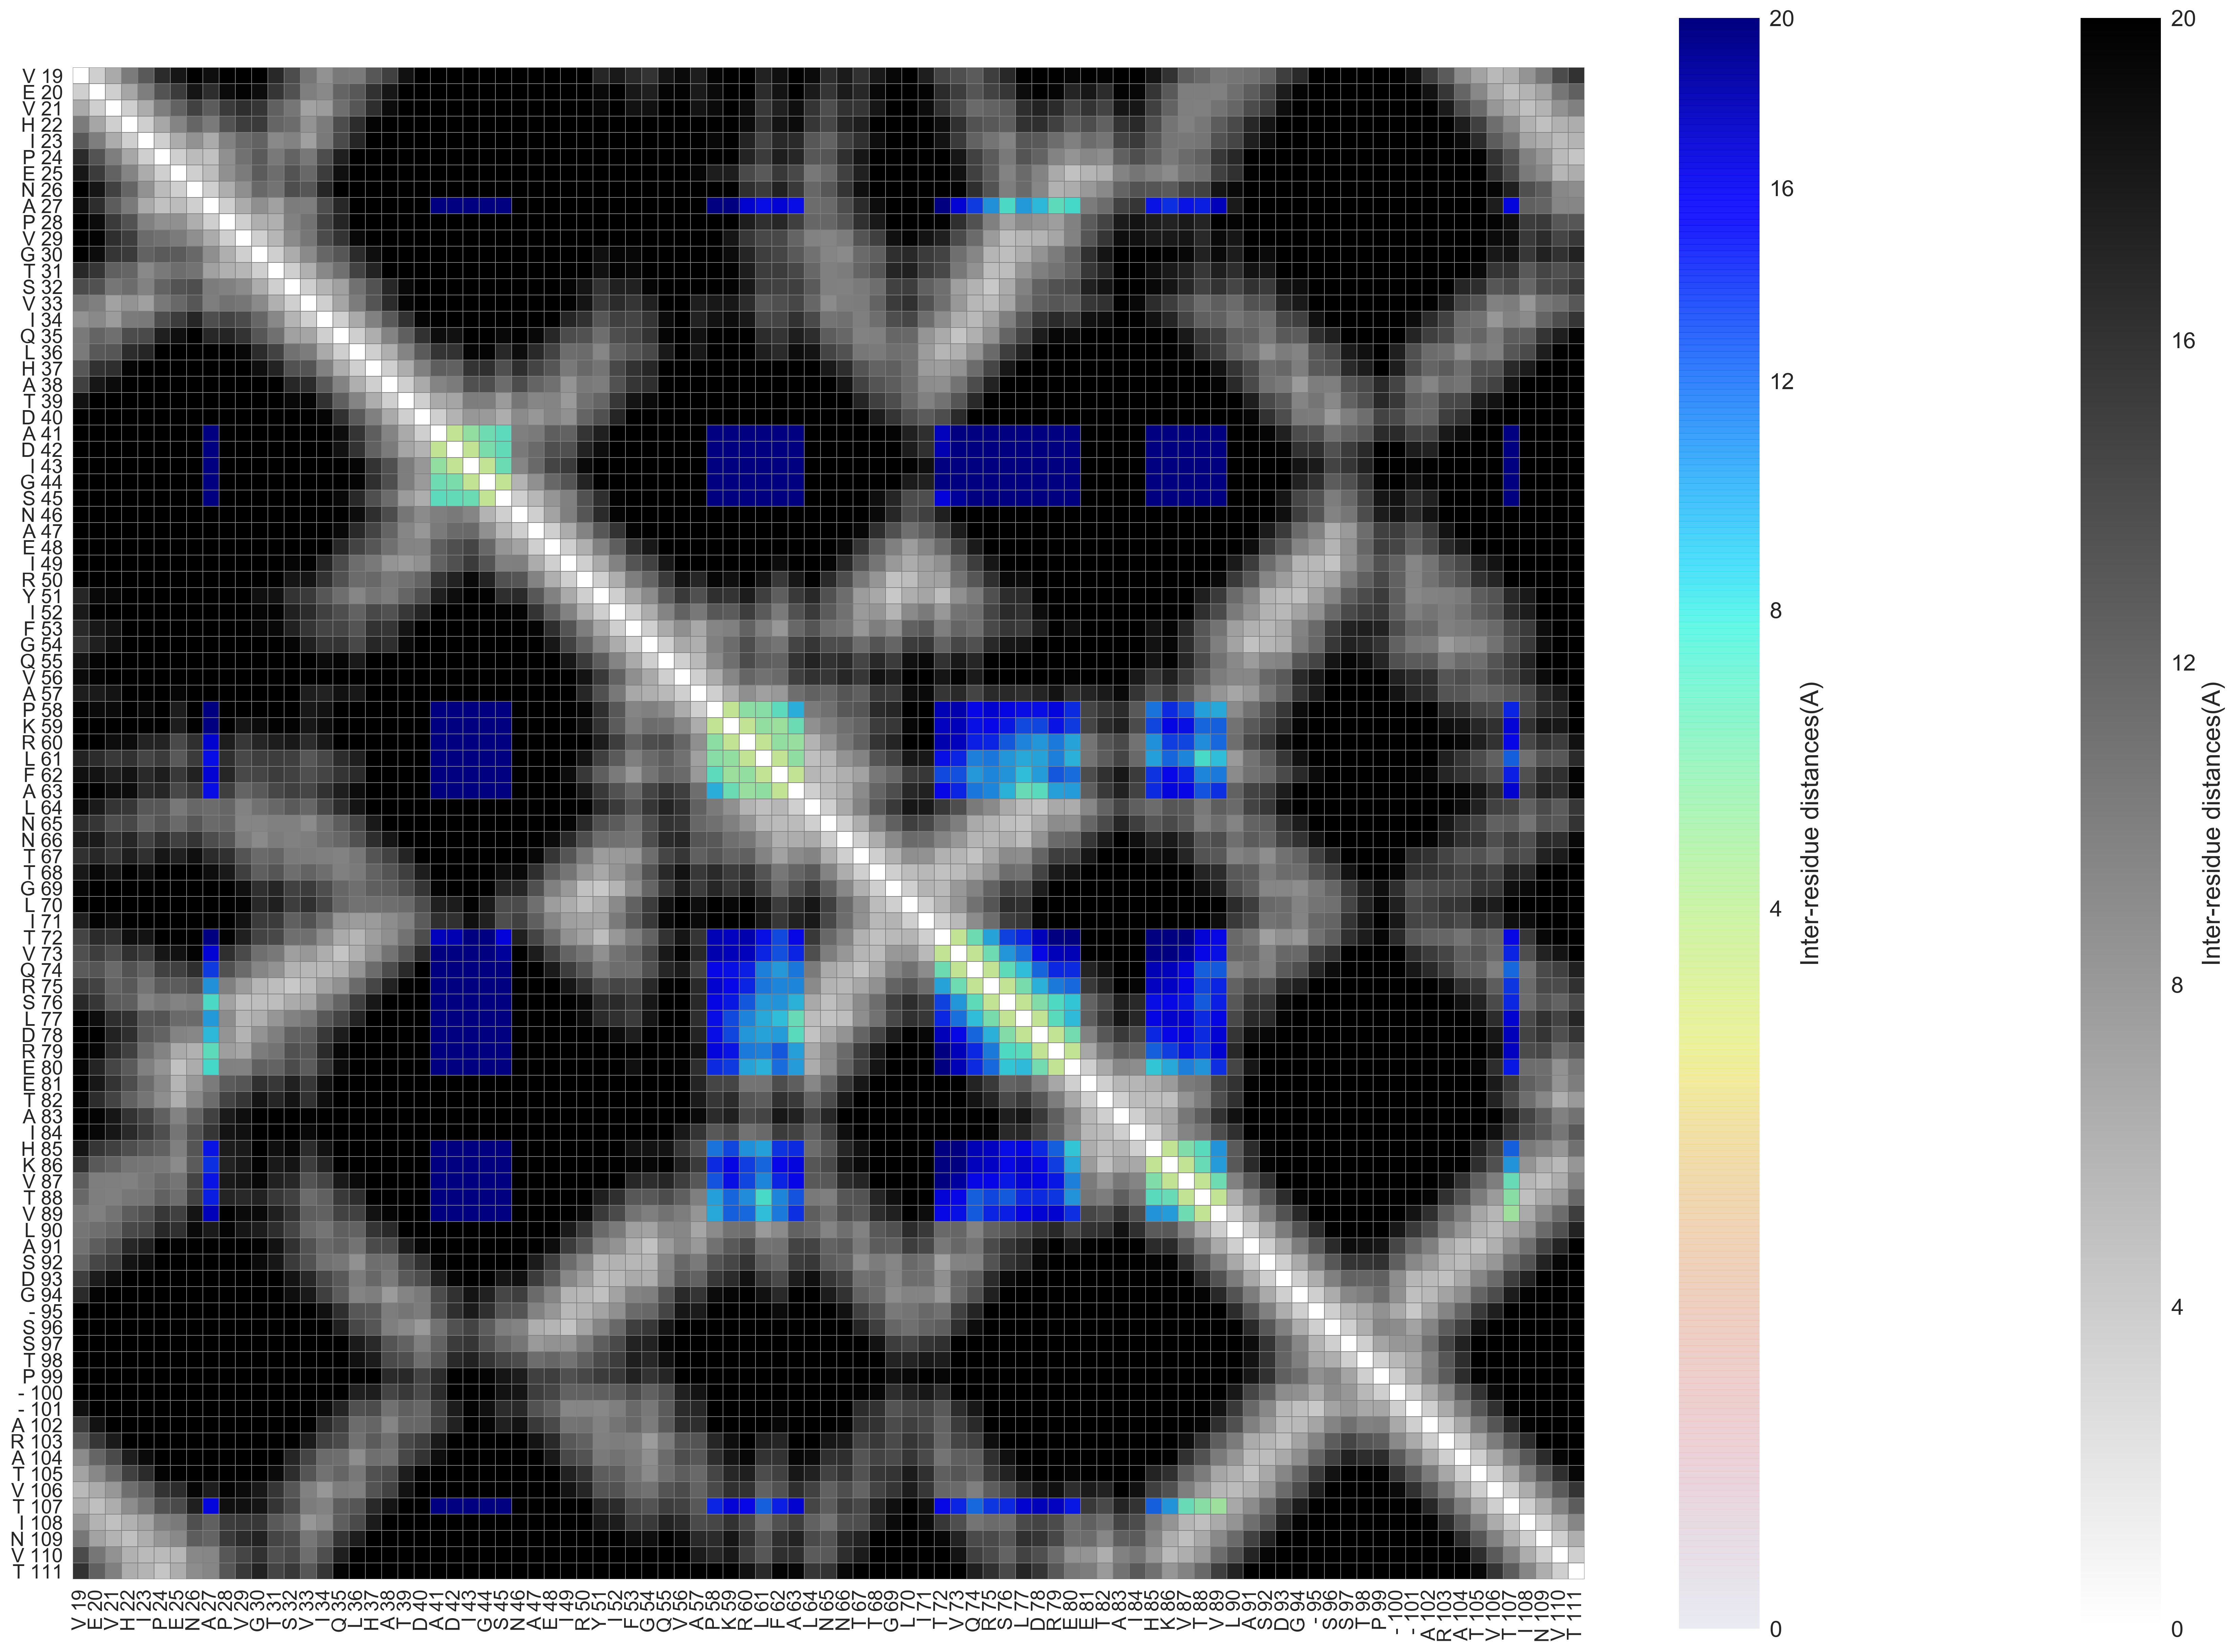

In [8]:
# Heatmaps
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal

Di = cPickle.load(open("Di3_2ee0.pkl","rb"))
Distances_=numpy.zeros((SEQ_LENGTH,SEQ_LENGTH))
for i in range(0,SEQ_LENGTH):
    for j in range(0,SEQ_LENGTH):
        Dij=(Di.loc[(Di[0]==i) & (Di[1]==j)][2].values)
        if not Dij:
            Dij=0
        Distances_[j,i]=Dij  
        
seaborn.set(font_scale=1.6)

cmap = plt.cm.jet_r
# Get the colormap colors
my_cmap = cmap(numpy.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = numpy.linspace(0, 1, cmap.N)
# Create new colormap
my_cmap = ListedColormap(my_cmap)

f, ax1 = plt.subplots(figsize=(30,30),dpi=300)
cmap_reversed = matplotlib.cm.get_cmap('gist_gray_r')
ax1 = seaborn.heatmap(Distances_, square=True, linewidths=.1, ax=ax1, cmap=cmap_reversed, 
                      linecolor='grey', vmin=0, vmax=20,
                      cbar_kws={'label':'Inter-residue distances(A)', 'shrink':0.7})
ax1 = seaborn.heatmap(dist1, square=True, linewidths=.1, ax=ax1,  norm=colors.PowerNorm(gamma=1./2.),
                      cmap=my_cmap, linecolor='grey',  vmin=0, vmax=20,
                      cbar_kws={'label':'Inter-residue distances(A)', 'shrink':0.7})
ax1.set_xticks(nums+.5); ax1.set_yticks((nums+.5)[::-1]);
ax1.set_xticklabels(xticks, rotation=90, fontsize=14);
ax1.set_yticklabels(xticks, rotation=0, fontsize=14);


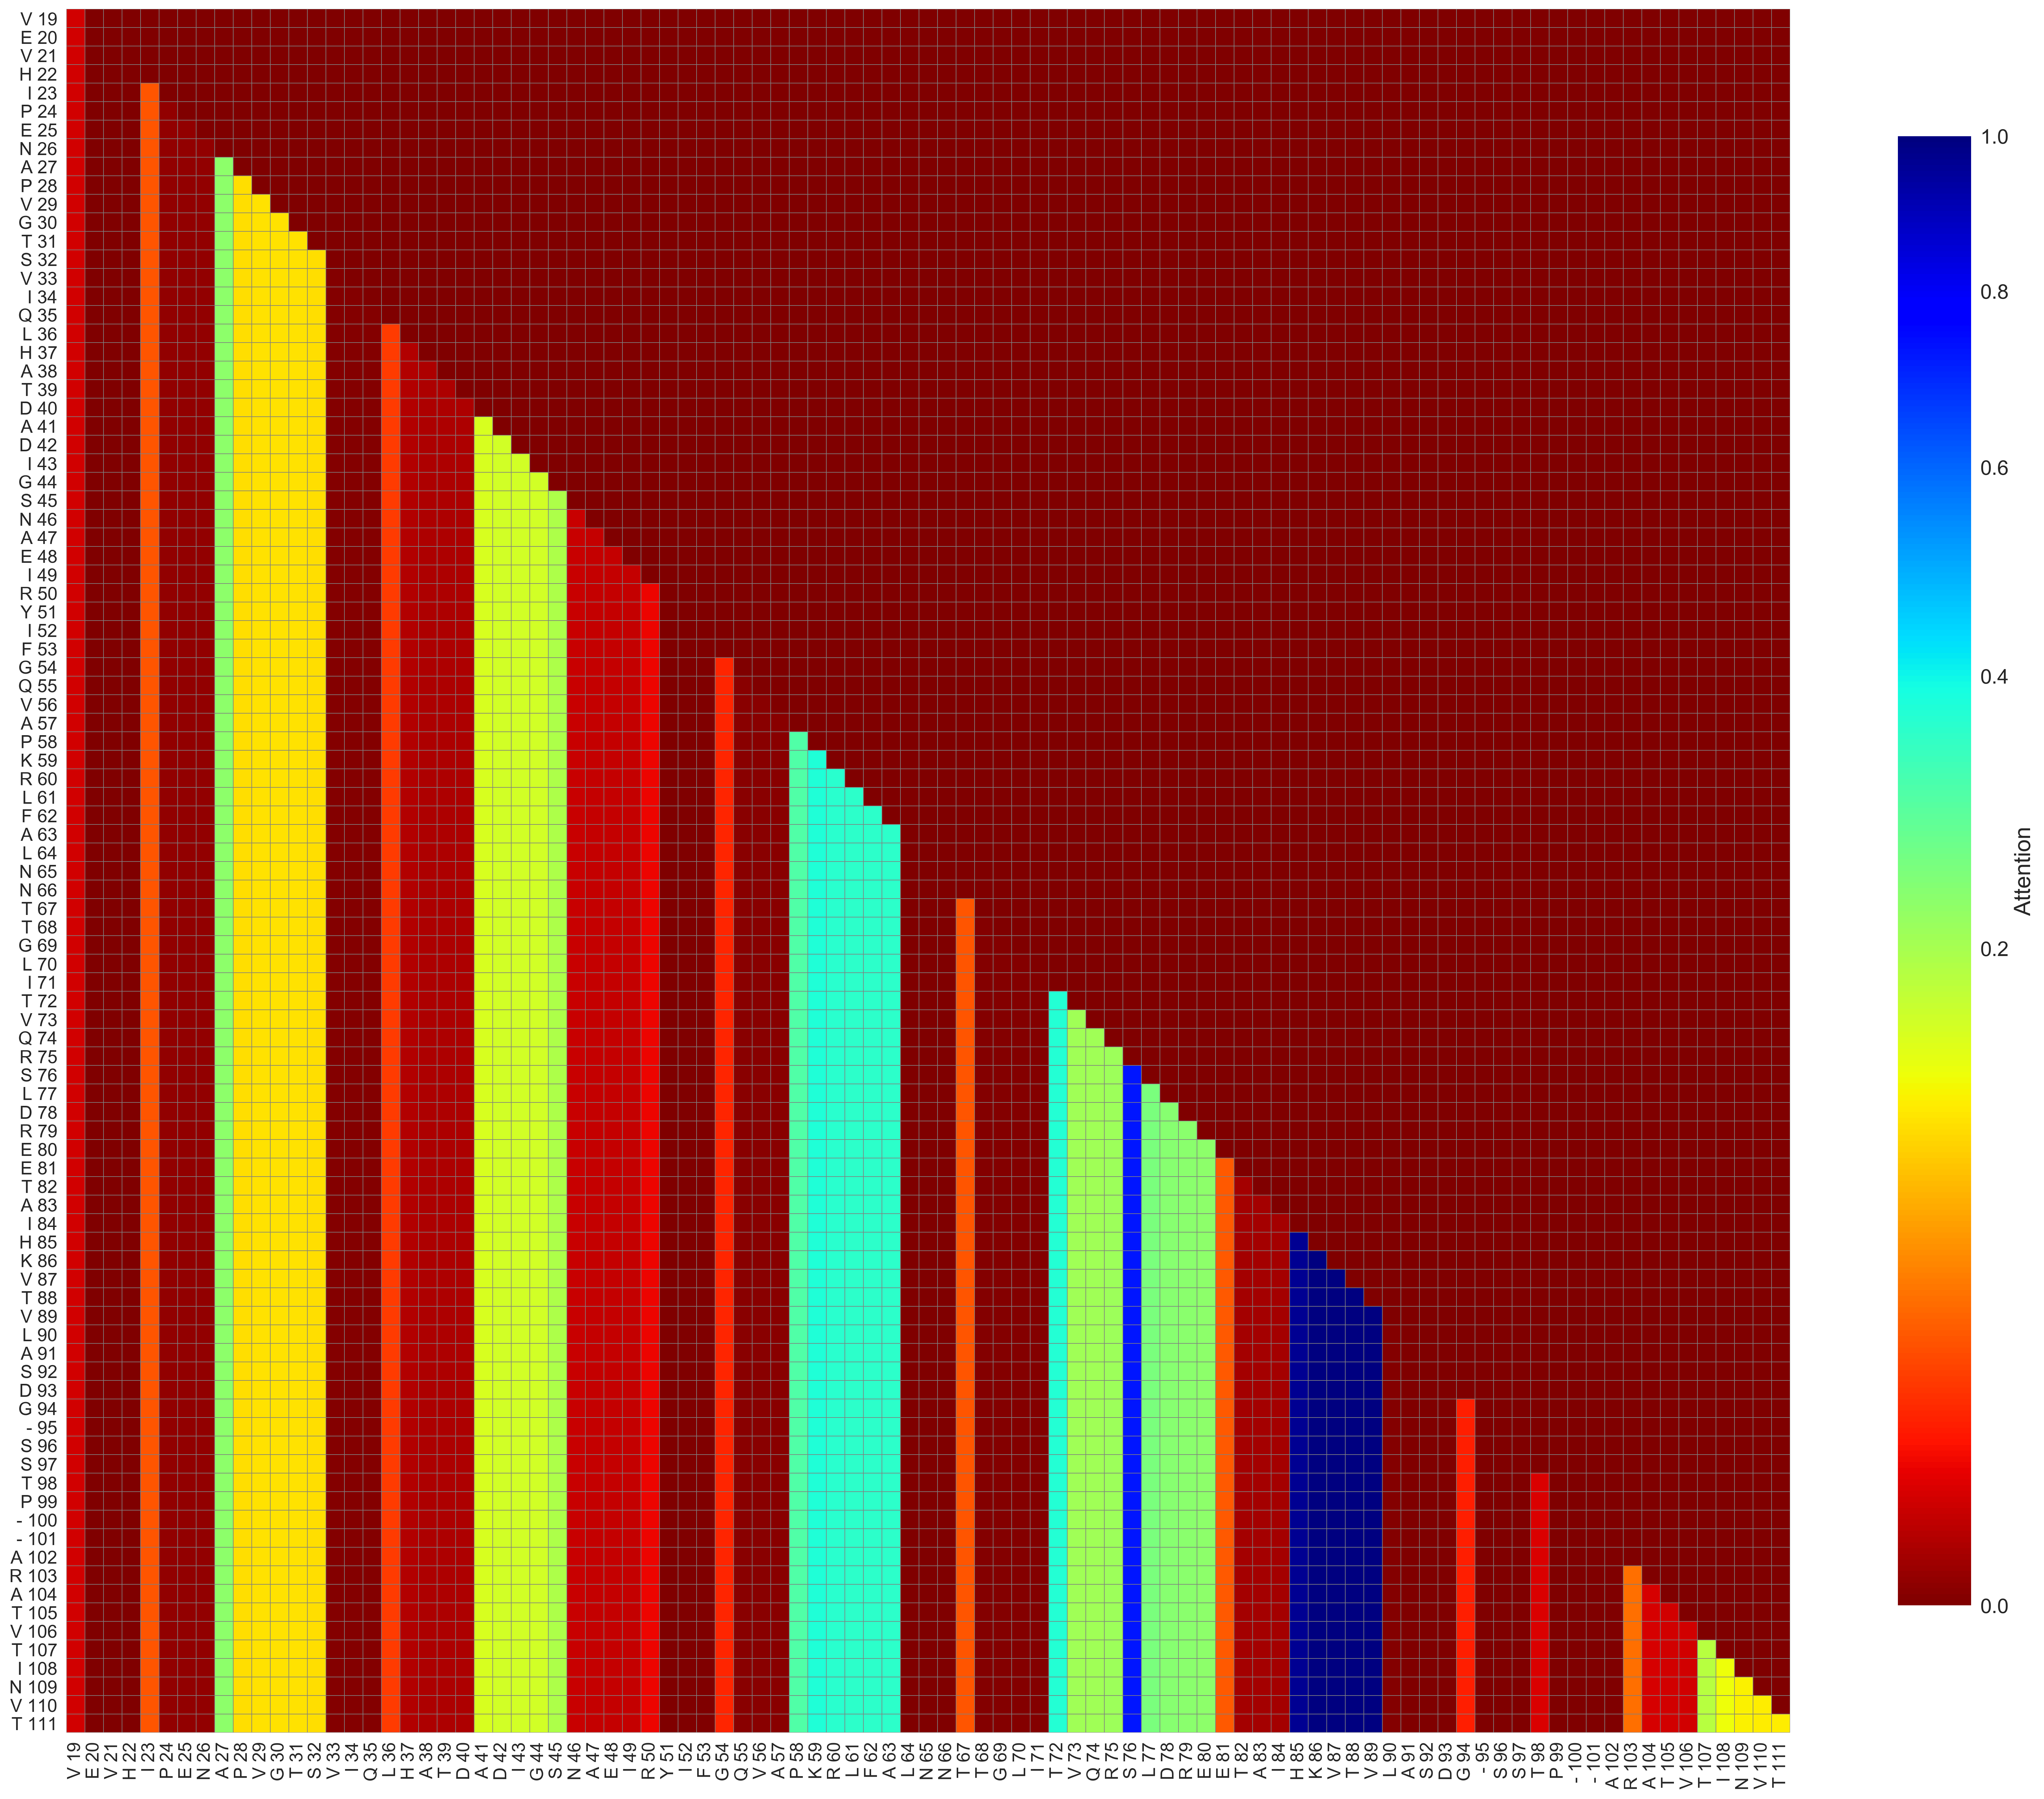

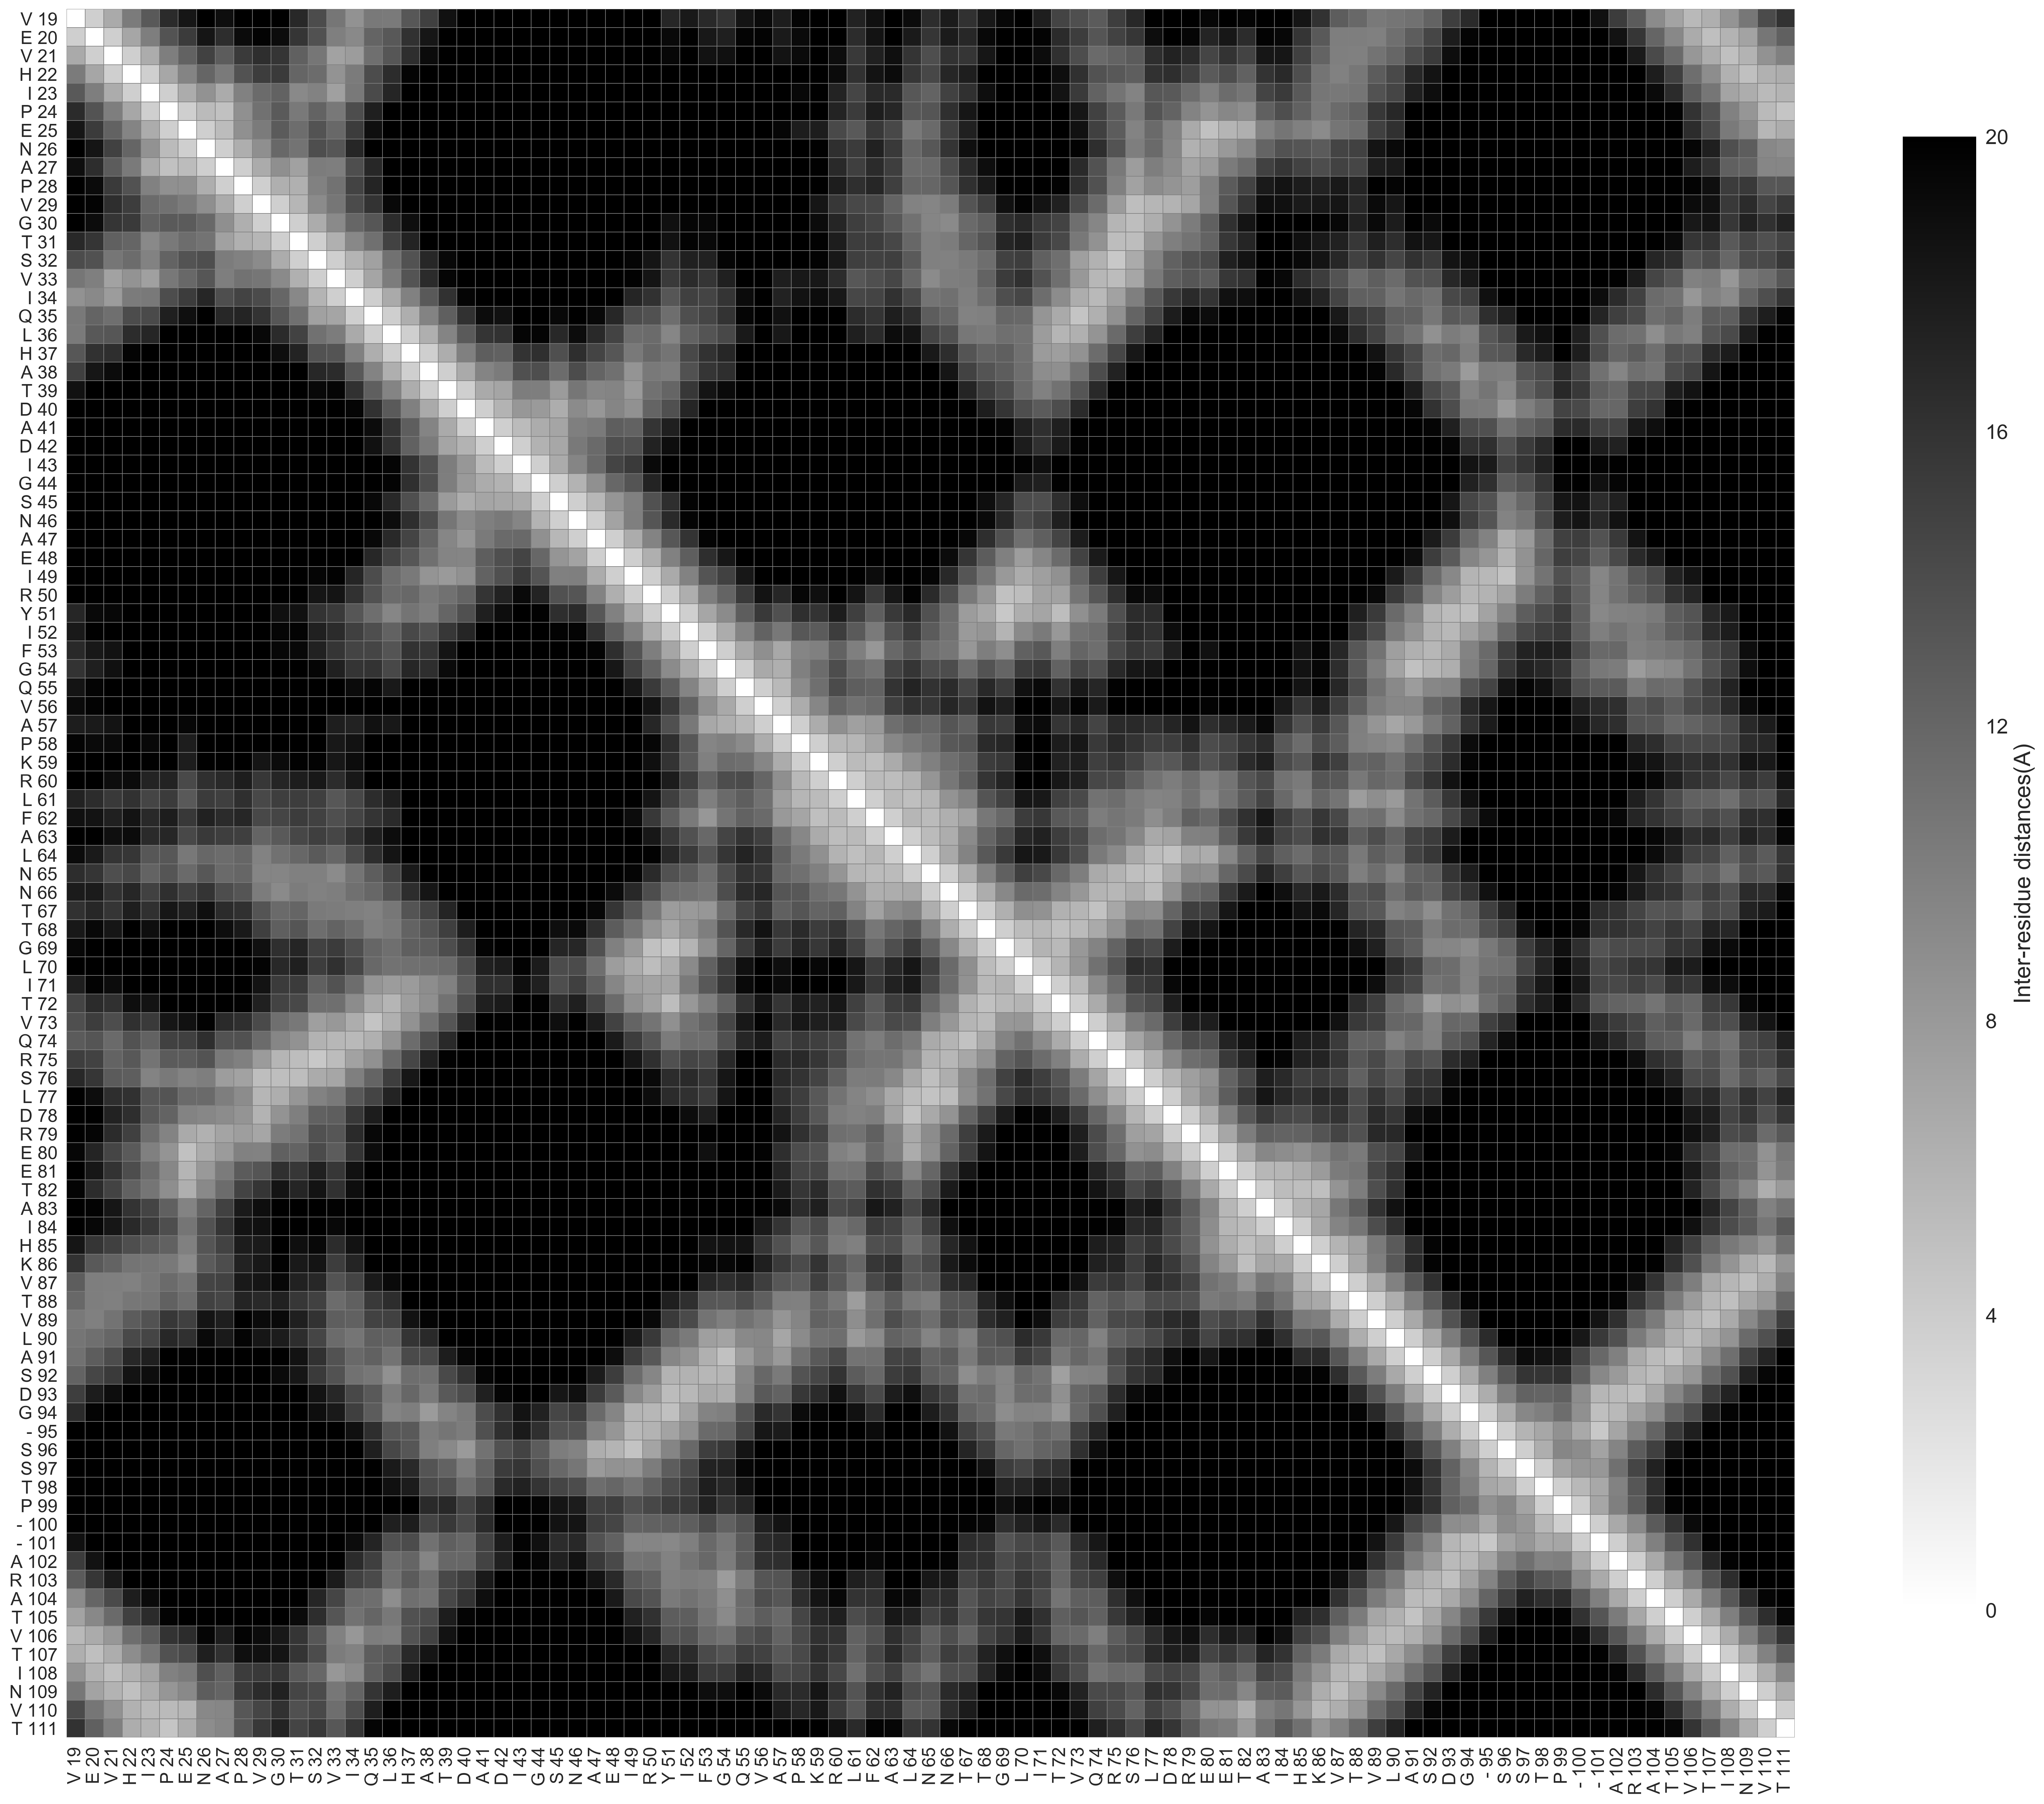

In [9]:
# Average data
my_cmap = plt.cm.jet_r

f, ax1 = plt.subplots(figsize=(30,30),dpi=300)
ax1 = seaborn.heatmap(data2, square=True, linewidths=.1, ax=ax1,  norm=colors.PowerNorm(gamma=1./2.), 
                      cmap=my_cmap, linecolor='grey',  
                      cbar_kws={'label':'Attention', 'shrink':0.7})
ax1.set_xticks(nums+.5); ax1.set_yticks((nums+.5)[::-1]);
ax1.set_xticklabels(xticks, rotation=90, fontsize=14);
ax1.set_yticklabels(xticks, rotation=0, fontsize=14);

f, ax1 = plt.subplots(figsize=(30,30),dpi=300)
ax1 = seaborn.heatmap(Distances_, square=True, linewidths=.1, ax=ax1, cmap=cmap_reversed, linecolor='grey', vmin=0, vmax=20,
                      cbar_kws={'label':'Inter-residue distances(A)', 'shrink':0.7})
ax1.set_xticks(nums+.5); ax1.set_yticks((nums+.5)[::-1]);
ax1.set_xticklabels(xticks, rotation=90, fontsize=14);
ax1.set_yticklabels(xticks, rotation=0, fontsize=14);



## SCA

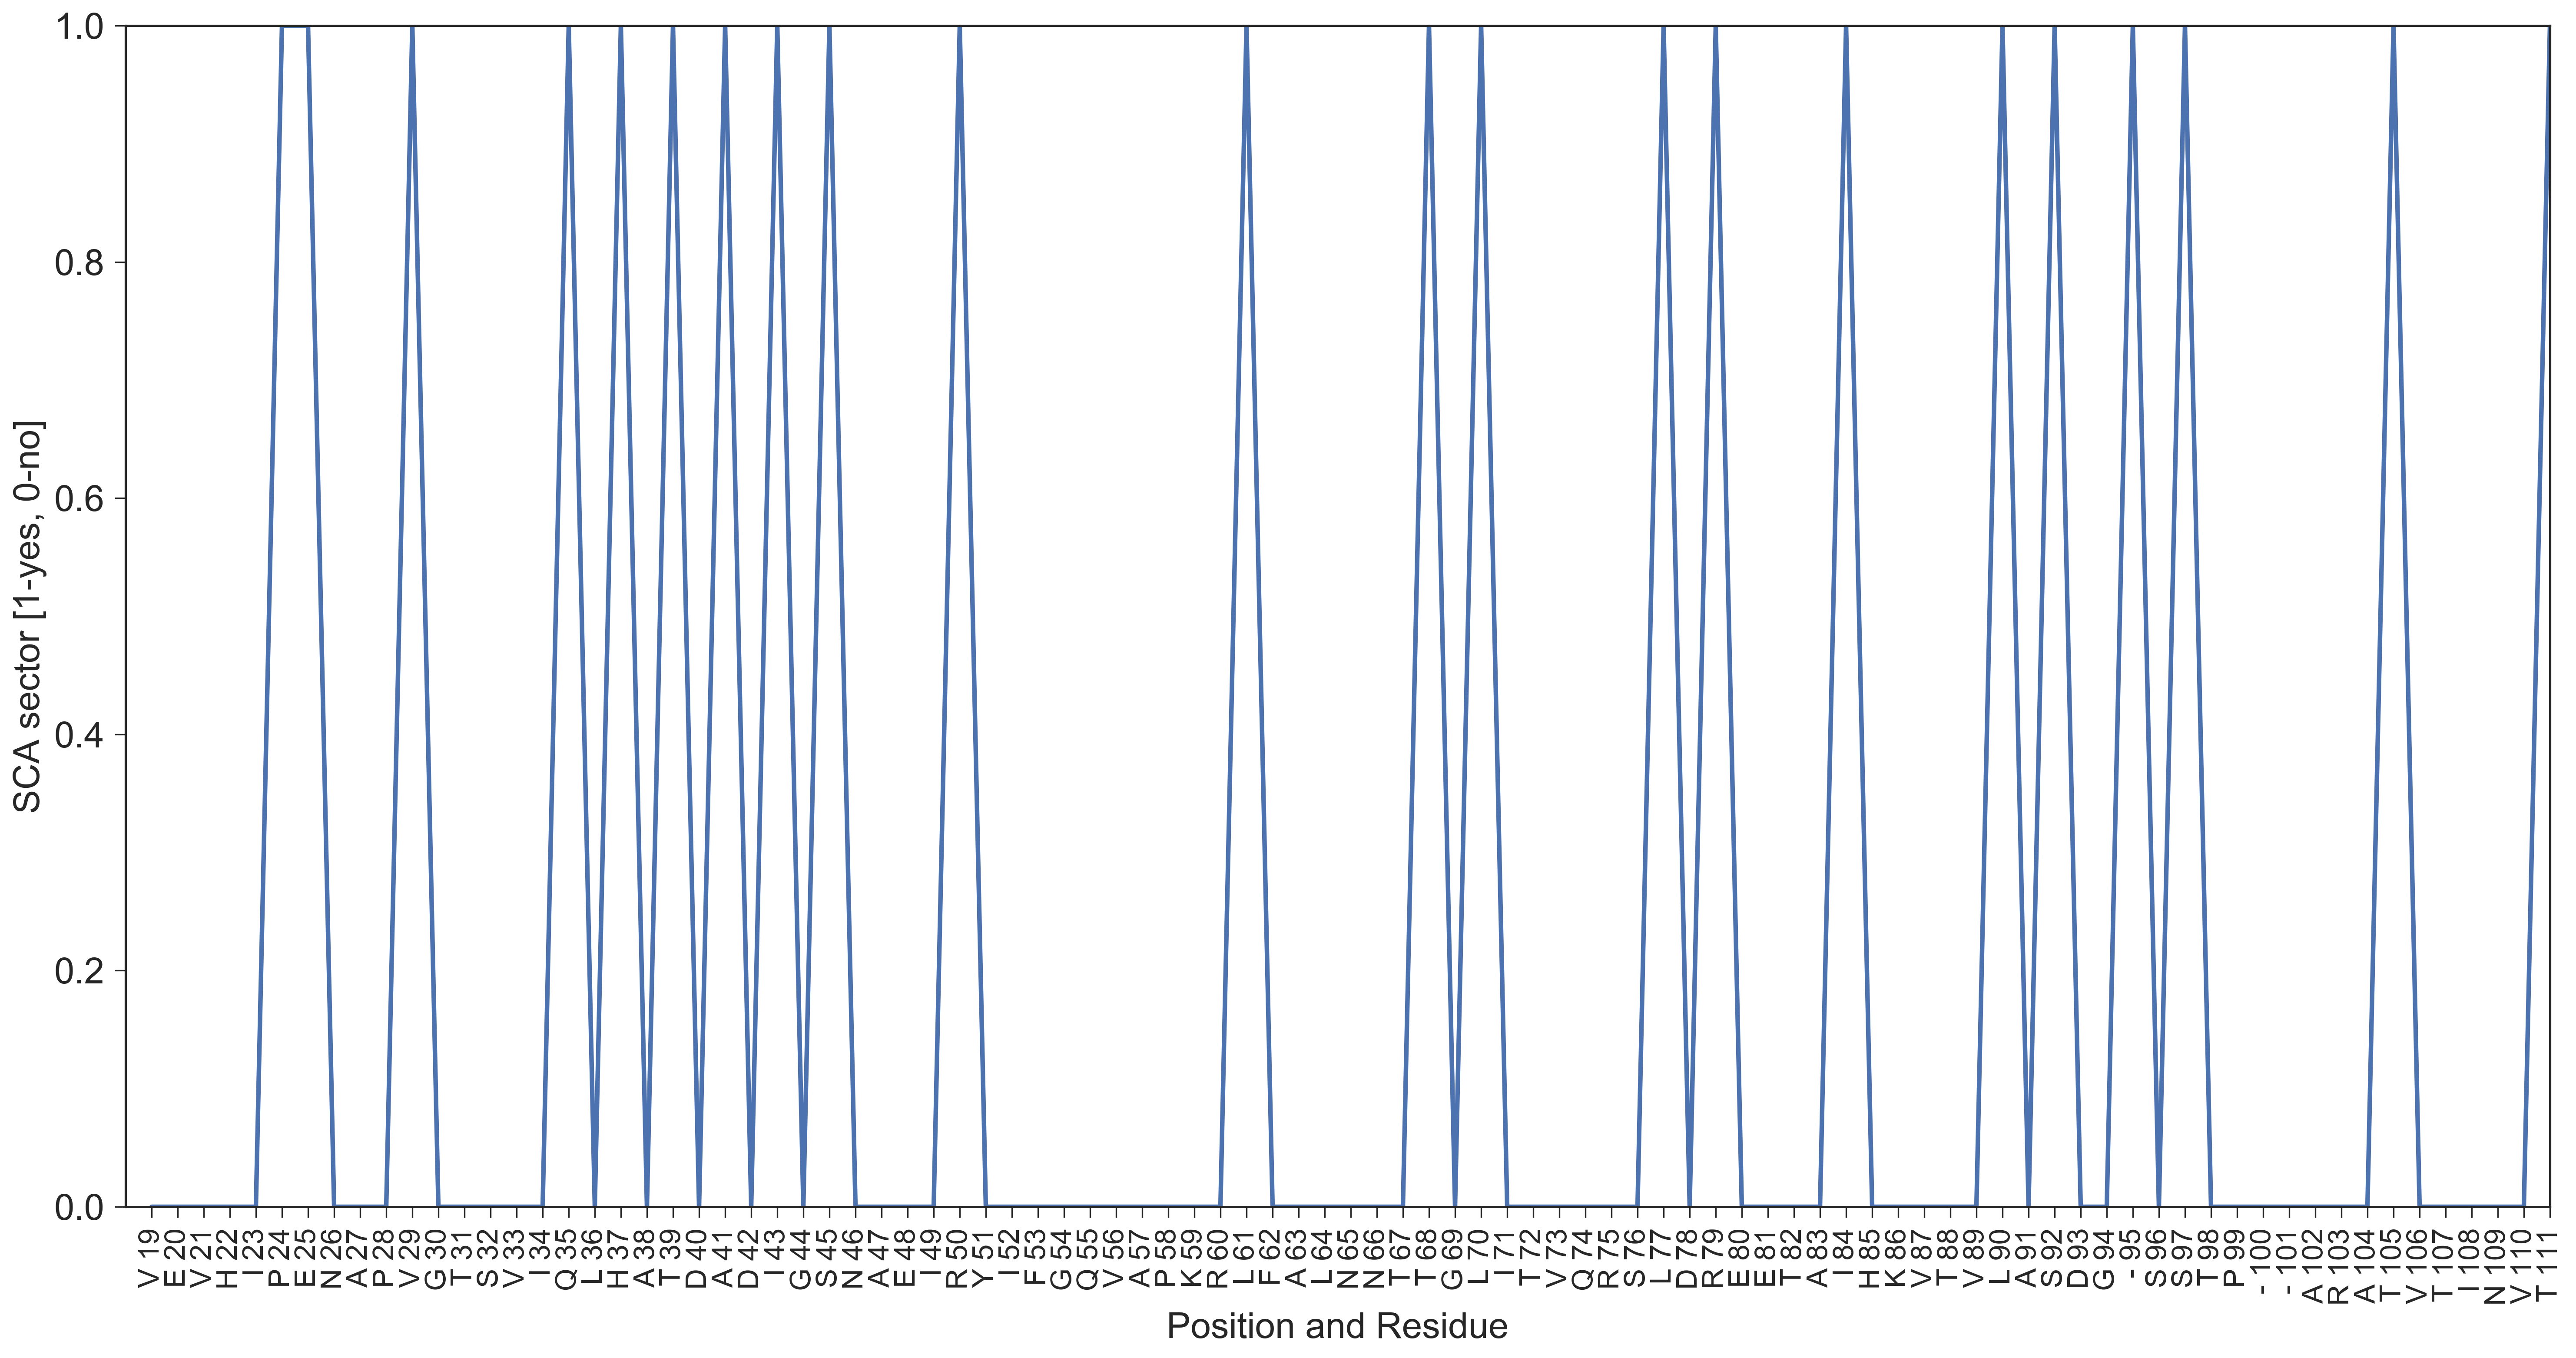

In [10]:
sca_resi = [18,24,25,29,35,37,39,41,43,45,50,61,68,70,77,79,84,90,92,95,97,105]


seaborn.set_style("white")
seaborn.set_style("ticks")
seaborn.set_context("paper",rc={"lines.linewidth": 2.5})
sca_attn = numpy.zeros(SEQ_LENGTH)
for i in range(0,len(sca_resi)):
    sca_resi[i] = sca_resi[i]-19
    sca_attn[sca_resi[i]] = 1


# Activation Plot
f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax = seaborn.tsplot(data=sca_attn);
ax.set_ylabel("SCA sector [1-yes, 0-no]", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)


# Sequence Logo
seq_dict = numpy.arange(SEQ_LENGTH)
dictionary = dict(zip(list(seq_dict), sca_attn))
draw_logo(SEQ_LENGTH,RES[0],sca_attn, 'Arial')



(0, 1)

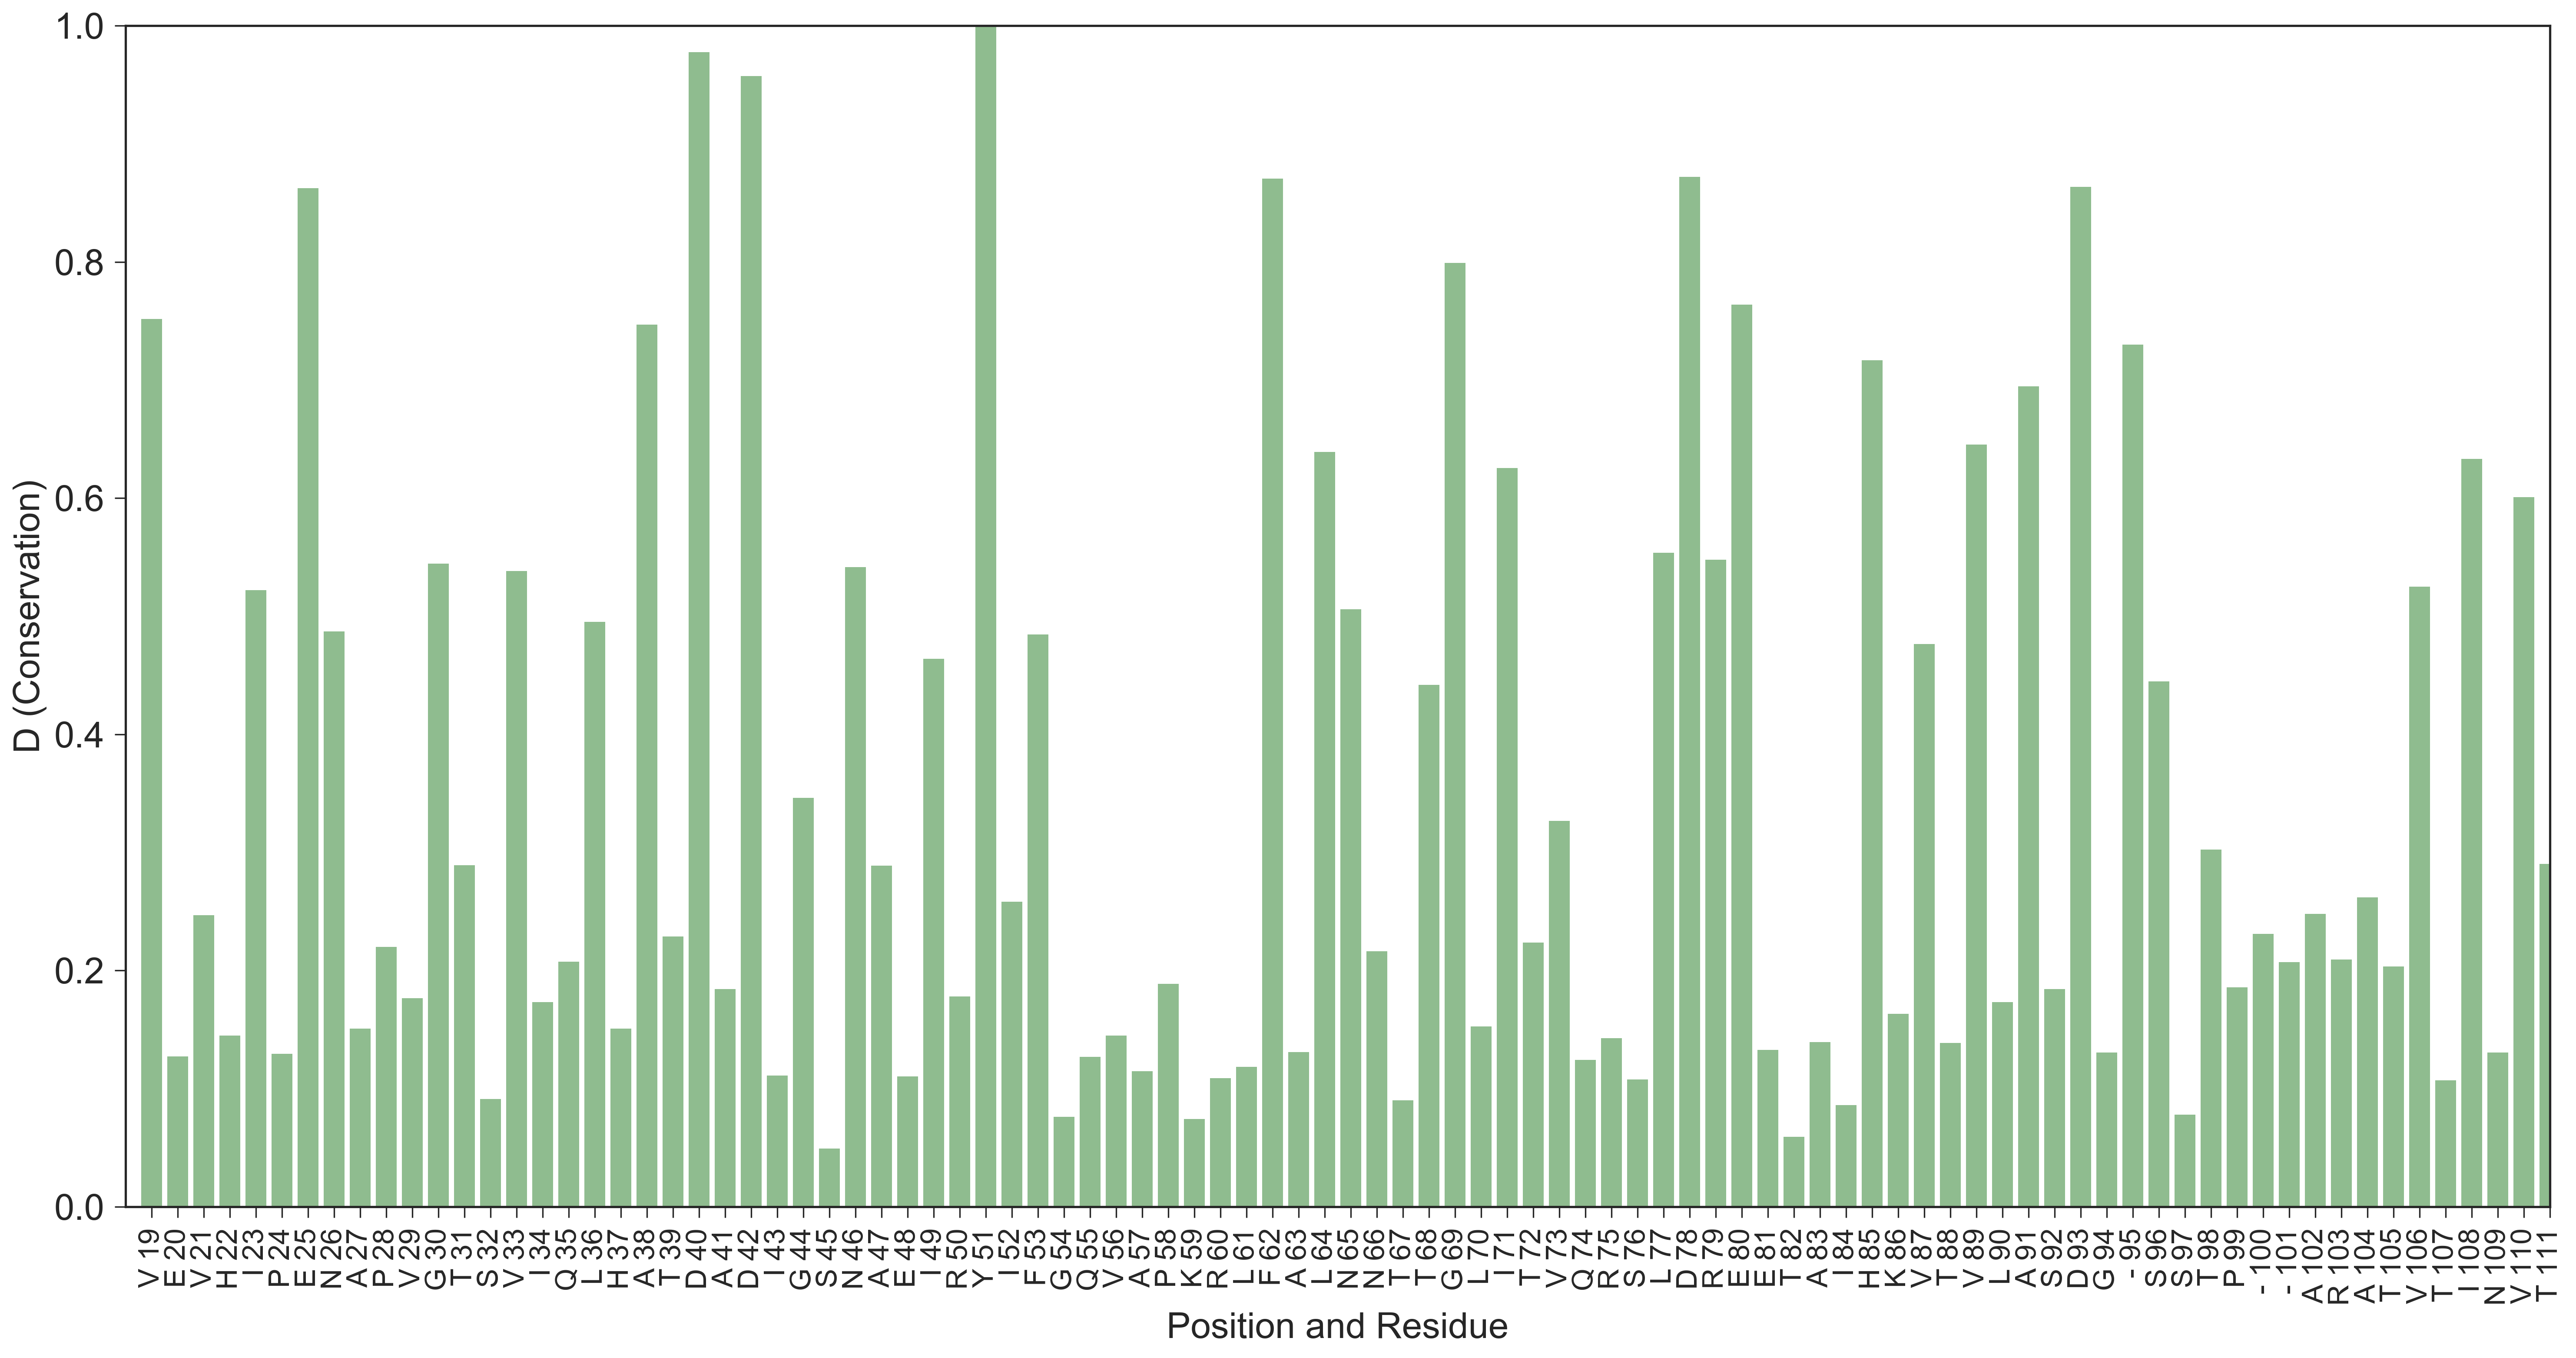

In [11]:
# Conservation
#  A global measure of conservation is similarly measured by D(f(i)||q') (where q' takes into
# account gaps, see Note 103, Section III.D)
D_glo =numpy.asarray([2.00894077238932, 0.340518424916322, 0.659773337453802, 0.387696188894822, 1.39541160327527, 0.345989740130278, 2.30504599644951, 1.30165315673344, 0.403436732115631, 0.587620728161205, 0.472260831628596, 1.45508409932172, 0.772978888745737, 0.243430871753490, 1.43890005275653, 0.463040782655464, 0.554992303296454, 1.32335151952261, 0.403413570068433, 1.99663017788457, 0.611412748211462, 2.61231220176567, 0.492344795859165, 2.55868544196218, 0.297329300209229, 0.925444220339983, 0.131542458478960, 1.44741559639422, 0.772162400582956, 0.295179321828842, 1.24023262102631, 0.476145422461197, 2.67272777873578, 0.690734994429137, 1.29532373194971, 0.203754909170000, 0.339412660389693, 0.387135579495672, 0.306912537987155, 0.504410027489207, 0.198618675045841, 0.291557424721100, 0.316855046653577, 2.32696536807788, 0.349730509008912, 1.70816560277759, 1.35215506282891, 0.578376902324550, 0.241169462235135, 1.18101276209896, 2.13585244814461, 0.408056858651054, 1.67149861800906, 0.597736195144269, 0.872923204389639, 0.332115394300353, 0.381455951792176, 0.287922038387911, 1.48012415183833, 2.33011938688379, 1.46460609736828, 2.04125008071308, 0.355000598534410, 0.158547256904217, 0.372358456012001, 0.229884582144486, 1.91588482662249, 0.436185207759090, 1.27379623970801, 0.370273064211866, 1.72518592490764, 0.463340039790337, 1.85641792019785, 0.493136395750808, 2.30770285229579, 0.348745253439713, 1.95112107745663, 1.18863969763650, 0.208416322152337, 0.808418162255916, 0.496862224597287, 0.617659240690175, 0.553216907668701, 0.662749884120889, 0.559941725593387, 0.699772976270188, 0.543717865693467, 1.40304456567077, 0.286092729049555, 1.69199644649567, 0.349332304799803, 1.60609282841226, 0.775723303946938])
D_glo = normalize(D_glo.reshape(-1, 1),norm='max',axis=0).ravel()

f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax1 = ax.bar(nums,D_glo, color='darkseagreen');
ax.set_ylabel("D (Conservation)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

F1: 0.8172043010752688 ROC AUC: 0.567775974025974


(0, 1)

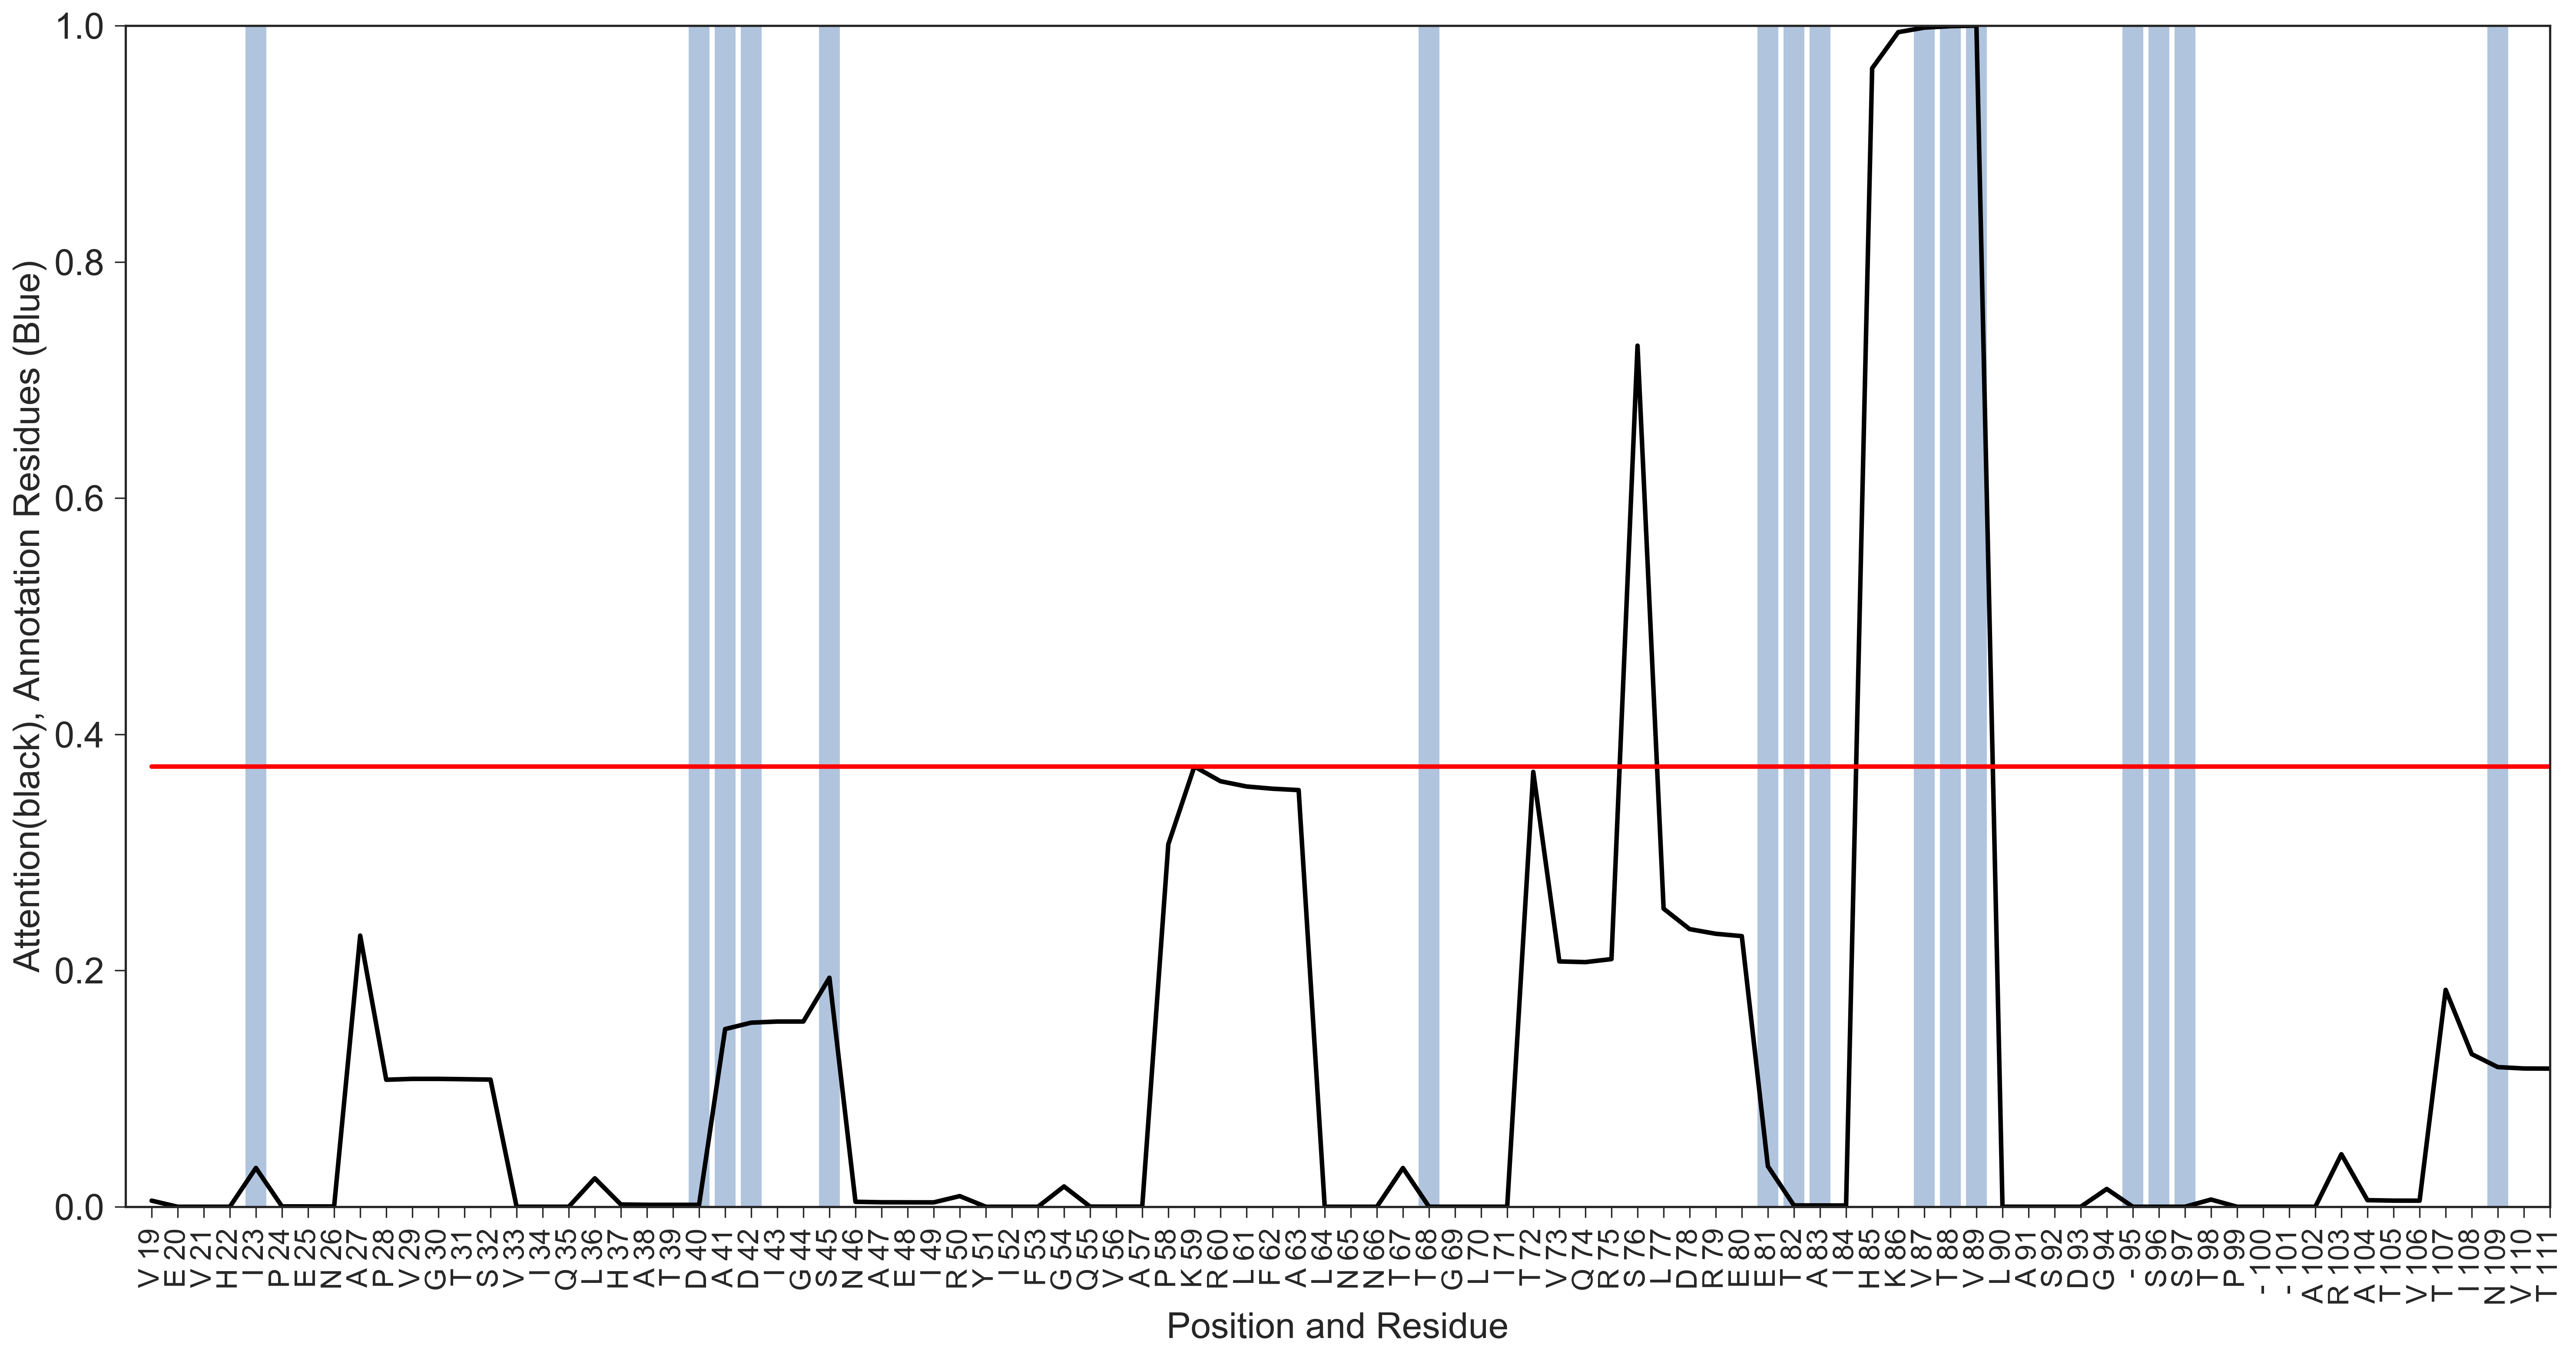

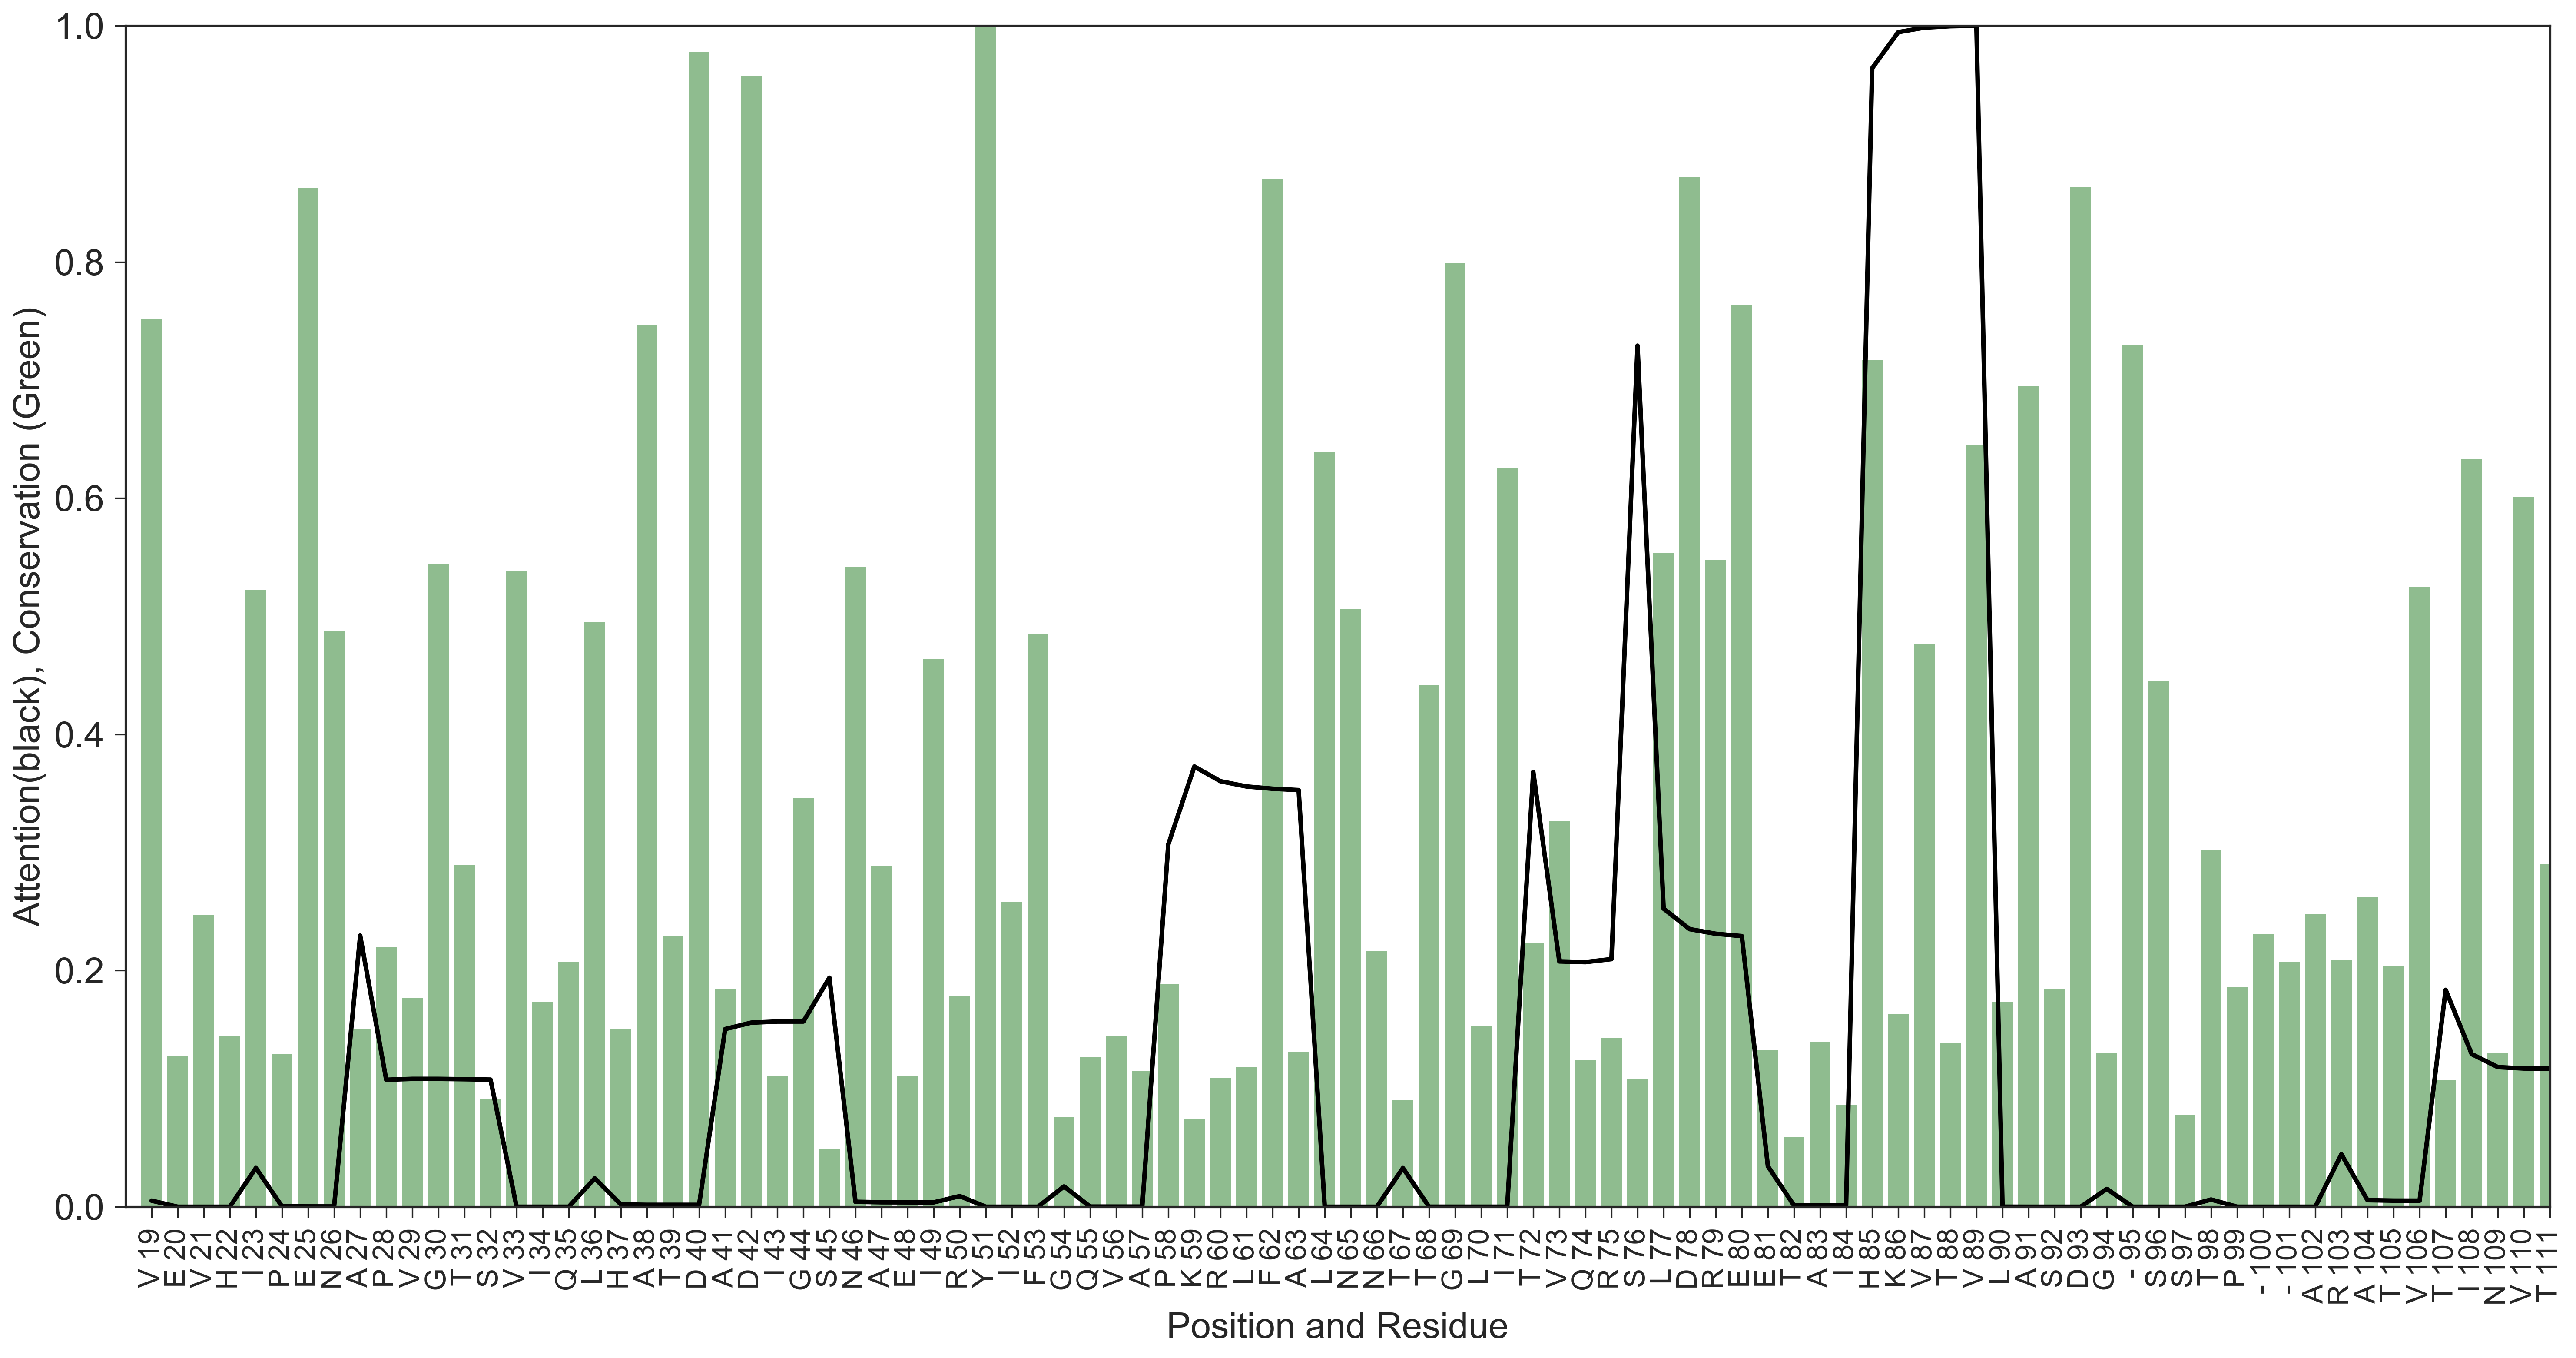

In [12]:
# Generate plots showing attention residues from annotations (in blue), HANprot result (in black)
# and HANprot against conservation (green and black)
from sklearn import metrics
seq_dict = numpy.arange(SEQ_LENGTH)

y = numpy.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0])
# Make attn = 1 if >0.1
y_ = numpy.zeros(SEQ_LENGTH)
y_ =[1*(data_[i]>(numpy.mean(data_)+1*numpy.std(data_))) for i in range(0,SEQ_LENGTH)  ]


data_auc=metrics.auc(nums, y_)
y_auc=metrics.auc(nums, y_)
roc_auc = metrics.roc_auc_score(y,numpy.array(y_))
from sklearn.metrics import f1_score
f1=f1_score(y,numpy.array(y_), average='micro')  
print("F1:", f1,"ROC AUC:", roc_auc)

f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = plt.bar(nums,y, color='lightsteelblue');
ax = seaborn.tsplot(data=data_, color='black');
ax.set_ylabel("Attention(black), Annotation Residues (Blue)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
threshold = (numpy.mean(data_)+1*numpy.std(data_))*numpy.ones(SEQ_LENGTH)
ax.plot(seq_dict,threshold, 'r');
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = plt.bar(nums,D_glo, color='darkseagreen');
ax = seaborn.tsplot(data=data_, color='black');
ax.set_ylabel("Attention(black), Conservation (Green)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)
